# Group #08
## Authors: Mariana Lavinha, Marta Dinis, Martim Santos, Patrícia Morais, Samuel Santos 
## Machine Learning course, 2022/23, NOVA IMS, MDSAA


## Index

[<font color='#E8800A'>1 - Import libraries</font>](#topic01) <br>
[<font color='#E8800A'>2 - Define functions to Handle data</font>](#topic02) <br>
[<font color='#E8800A'>3 - Descriptive Statistics</font>](#topic03) <br>
[<font color='#E8800A'>4 - Data Preprocessing</font>](#topic04) <br>
[<font color='#E8800A'>5 - Algorythm Chains: Pipelines and Column Transformers</font>](#topic05) <br>
[<font color='#E8800A'>6 - Assessing several models with our data</font>](#topic06) <br>
[<font color='#E8800A'>7 - Optimized search for the ideal Hyperparameter : RandomForest()</font>](#topic07) <br>
[<font color='#E8800A'>8 - Optimized search for the ideal Hyperparameter : Neural Networks</font>](#topic08) <br>
[<font color='#E8800A'>9 - Ensembles</font>](#topic09) <br>
[<font color='#E8800A'>10 - Comparing our models</font>](#topic10) <br>
[<font color='#E8800A'>11 - Final Model</font>](#topic11) <br>
[<font color='#E8800A'>12 - Predictions for the Test Data</font>](#topic12) <br>

<a class="anchor" id="topic01"> <br>
## Step 1: Import of all needed libraries


In [1]:
#!pip install feature_engine
#!pip install xgboost

In [2]:
import sklearn

import sqlite3
import os
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn import preprocessing
from scipy.spatial import distance_matrix
from scipy.stats import loguniform
from scipy.stats import chi2_contingency

import time, datetime

from scipy import stats # for chi squared

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

from sklearn.base import TransformerMixin, BaseEstimator
from feature_engine.selection import DropFeatures

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.datasets import make_classification

from matplotlib import pyplot

from sklearn.svm import SVR

import xgboost as xg

import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="topic02" /><br>
## Step 2: Define functions to handle data


### 2.1 Create a print function variant that can be turned on/off 


In [3]:
g_verbose_mode = False
g_random_state = 53

In [4]:
def vprint(*print_params):
    '''Works the same way as print, but only actually outputs if global variable g_verbose_mode = True
    Otherwise, nothing happens. This enables us to run the notebook in a more concise or more verbose mode.'''
    if g_verbose_mode:
        print(*print_params)


### 2.2 Input file initial handling
Open files, merge them and invoque the preprocessing function

In [5]:
def filepath(filename):
    return "../input/the-smith-parasite/" + filename + ".xlsx"


def getdataset(dataset_name):
    '''getDataSet accepts two strings as parameter: "train" or "test"'''
    demo = pd.read_excel(filepath(dataset_name + "_demo" ))
    demo.set_index('PatientID',inplace=True)
    habits = pd.read_excel(filepath(dataset_name + "_habits" ))
    habits.set_index('PatientID',inplace=True)
    health = pd.read_excel(filepath(dataset_name + "_health" ))
    health.set_index('PatientID',inplace=True)
    returndata= pd.concat([demo,habits,health], axis=1)
    
    # Do the stuff that is common to both train and test data
    returndata = preprocess(returndata)
    
    return returndata


### 2.3 Preprocess data after getting it from the input files

In [6]:
def preprocess( inputdf):
    '''This function gets a dataframe and does all the manipulation that is to be applied to both train and test data.
    This ensures consistency and reduces the code that we have to maintain.
    Handling that is specific to train data (ex. model fitting) is outside this function.'''
    
    ## Feature Engineering
    #ADD BMI
    #inputdf['G8_BMI'] = inputdf['Weight']/(inputdf['Height']/100)**2
    #inputdf.drop(['Weight','Height'],axis=1,inplace=True)
    
    #Drop the variable Name and create the variable Gender
    inputdf['Gender'] = list(map(lambda x: 1 if int(x[0:4]=="Mr. ") else 0, inputdf['Name']))
    inputdf.drop(['Name'],axis=1,inplace=True) 
    
    #Create a new variable age and drop the variable Birth_Year
    inputdf['Age']=list(map(lambda x: (2022-x) if (2022-x > 0) and (2022-x <= 100) else np.NaN, inputdf['Birth_Year'])) 
    inputdf.drop(['Birth_Year'],axis=1,inplace=True)

    #Replace the values in the variables 'Smoking_Habit' and 'Exercise' for 1 and 0 (Can we transform this in fit transform function?)
    inputdf['Smoking_Habit'].replace(['Yes','No'],[1, 0],inplace=True)
    inputdf['Exercise'].replace(['Yes','No'],[1, 0],inplace=True)

    #Inconsistent Values 
    inputdf['Mental_Health']=list(map(lambda x: x if x >= 0 and x <= 30 else np.NaN, inputdf['Mental_Health'])) 
    inputdf['Physical_Health']=list(map(lambda x: x if x >= 0 and x <= 30 else np.NaN, inputdf['Physical_Health'])) 
    inputdf['High_Cholesterol']=list(map(lambda x: x if x <=500 else np.NaN, inputdf['High_Cholesterol'])) 
    
    #Capitalizing string columns
    for column in list(inputdf.select_dtypes(include=['object']).columns):
        inputdf[column] = inputdf[column].str.capitalize()

    return inputdf

### 2.4 Creating functions to test the performance of our models

In [7]:
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state = g_random_state)

In [8]:
def return_f1score(model, X, y):
    n_scores = cross_val_score(model, X, y, scoring = 'f1', cv = cv)
    return n_scores

In [9]:
def myreturn_results(models, X, y, title):
    results, names = [],[]
    retvalues = []
    for name, model in models.items():
        scores = return_f1score(model, X, y)
        results.append(scores)
        names.append("{}\n{:.3f}".format(name, scores.mean()))
        vprint('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
        retvalues.append([name, scores.mean()])
        
    plt.figure(figsize=(15,7))
    plt.boxplot(results, labels = names, showmeans = True)
    plt.xticks(fontsize=10)
    plt.title(title)
    plt.show()
    return retvalues

### 2.5 Function to evaluate or models using an approach that is less sensitive to the split performed
Function receives a split_method (eg. KFold), a dataset, a target and a pipeline
It prints the average score of that pipeline for that dataset using the provided split method


In [10]:
def avg_score(split_method,X,y, pipeline):
    '''avg_score receives a split_method (tipically, K_Fold), a data set, a target variable and a fitted pipeline.
    The split_method is used to separate the dataset between train and validation. The pipeline's performance
    is measured for both train and validation data.
    The function prints the average score for for both train and validation and train, and its difference.'''
    score_train = []
    score_val = []
    for train_index, val_index in split_method.split(X,y): #split_method.split(X) applies the 10 splits into our data set
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        predictions_train = pipeline.predict(X_train)
        predictions_val = pipeline.predict(X_val)

        value_train = f1_score(predictions_train, y_train)
        value_val = f1_score(predictions_val,y_val)
        score_train.append(value_train)
        score_val.append(value_val)

    print('Train average score:' +  str(round(np.mean(score_train),3)) + '+/-' + str(round(np.std(score_train),3)))
    print('Val average score:' +  str(round(np.mean(score_val),3)) + '+/-' + str(round(np.std(score_val),3)))
    print('Overfitting abs(Train-Val):' +  str(round(abs(np.mean(score_train)-np.mean(score_val)),3)) )


<a class="anchor" id="topic03"> <br>
## Step 3 - Descriptive Statistics 

### Step 3.1 Load data from the files provided, and "preprocess" them

Preprocessing includes the operations that are common to all datasets - train, validation and test.

In [11]:
train_data = getdataset("train")
test_data = getdataset("test")

In [12]:
train_data.head()

,Region,Education,Disease,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes,Gender,Age
PatientID,,,,,,,,,,,,,,,,,,
1167,London,High school incomplete (10th to 11th grade),1,0,I usually consume alcohol every day,1,Less than 1. i do not consume fruits every day.,Between one liter and two liters,155,67,358.0,120,21,2,More than 3 years,Neither i nor my immediate family have diabetes.,0,57.0
1805,South west,High school incomplete (10th to 11th grade),1,0,I consider myself a social drinker,1,Less than 1. i do not consume fruits every day.,Between one liter and two liters,173,88,230.0,142,9,0,Not sure,Neither i nor my immediate family have diabetes.,1,53.0
1557,Yorkshire and the humber,Elementary school (1st to 9th grade),1,0,I consider myself a social drinker,0,Less than 1. i do not consume fruits every day.,More than half a liter but less than one liter,162,68,226.0,122,26,0,More than 3 years,Neither i nor my immediate family have diabetes.,1,48.0
1658,London,University complete (3 or more years),0,0,I usually consume alcohol every day,1,Less than 1. i do not consume fruits every day.,More than half a liter but less than one liter,180,66,313.0,125,13,8,Not sure,I have/had pregnancy diabetes or borderline di...,1,64.0
1544,South east,University incomplete (1 to 2 years),1,0,I consider myself a social drinker,0,1 to 2 pieces of fruit in average,More than half a liter but less than one liter,180,58,277.0,125,18,2,More than 3 years,I have/had pregnancy diabetes or borderline di...,1,54.0


Defining the lists that we need to use:

In [13]:
#Define the columns of each nature
non_ordinal_cat = ['Region','Checkup','Diabetes']
ord_cat = ['Education','Drinking_Habit','Fruit_Habit','Water_Habit']
bin_cat = ['Smoking_Habit','Exercise','Gender']    
cat = non_ordinal_cat + ord_cat

num = ['Height','Weight','High_Cholesterol','Blood_Pressure','Mental_Health','Physical_Health', 'Age']

# Categories of ordinal features, capitalized
edu = ['I never attended school / other','Elementary school (1st to 9th grade)','High school incomplete (10th to 11th grade)','High school graduate','University incomplete (1 to 2 years)','University complete (3 or more years)']
water = ['Less than half a liter','More than half a liter but less than one liter', 'Between one liter and two liters']
fruit = ['Less than 1. i do not consume fruits every day.','1 to 2 pieces of fruit in average', '3 to 4 pieces of fruit in average','5 to 6 pieces of fruit in average','More than six pieces of fruit']
drink = ['I do not consume any type of alcohol','I consider myself a social drinker', 'I usually consume alcohol every day']

### Step 3.2 Basic Data Analysis

**Summary of the Dataframe**

In [14]:
train_data.shape

(800, 18)

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1167 to 1117
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Region            800 non-null    object 
 1   Education         787 non-null    object 
 2   Disease           800 non-null    int64  
 3   Smoking_Habit     800 non-null    int64  
 4   Drinking_Habit    800 non-null    object 
 5   Exercise          800 non-null    int64  
 6   Fruit_Habit       800 non-null    object 
 7   Water_Habit       800 non-null    object 
 8   Height            800 non-null    int64  
 9   Weight            800 non-null    int64  
 10  High_Cholesterol  797 non-null    float64
 11  Blood_Pressure    800 non-null    int64  
 12  Mental_Health     800 non-null    int64  
 13  Physical_Health   800 non-null    int64  
 14  Checkup           800 non-null    object 
 15  Diabetes          800 non-null    object 
 16  Gender            800 non-null    int64 

**Null Values**

In [16]:
train_data.isnull().sum()

Region               0
Education           13
Disease              0
Smoking_Habit        0
Drinking_Habit       0
Exercise             0
Fruit_Habit          0
Water_Habit          0
Height               0
Weight               0
High_Cholesterol     3
Blood_Pressure       0
Mental_Health        0
Physical_Health      0
Checkup              0
Diabetes             0
Gender               0
Age                 12
dtype: int64

**Statistical Description**

In [17]:
#describe( ) function 
train_data.describe()

,Disease,Smoking_Habit,Exercise,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Gender,Age
count,800.000000,800.000000,800.000000,800.000000,800.00000,797.000000,800.000000,800.000000,800.000000,800.000000,788.000000
mean,0.513750,0.158750,0.330000,167.806250,67.82750,248.122961,131.053750,17.345000,4.558750,0.705000,54.408629
std,0.500124,0.365671,0.470507,7.976888,12.11347,47.801174,17.052693,5.385139,5.449189,0.456328,8.994734
min,0.000000,0.000000,0.000000,151.000000,40.00000,130.000000,94.000000,0.000000,0.000000,0.000000,29.000000
25%,0.000000,0.000000,0.000000,162.000000,58.00000,213.000000,120.000000,13.000000,0.000000,0.000000,48.000000
50%,1.000000,0.000000,0.000000,167.000000,68.00000,244.000000,130.000000,18.000000,3.000000,1.000000,56.000000
75%,1.000000,0.000000,1.000000,173.000000,77.00000,279.000000,140.000000,21.000000,7.000000,1.000000,61.000000
max,1.000000,1.000000,1.000000,180.000000,97.00000,421.000000,200.000000,29.000000,30.000000,1.000000,77.000000


In [18]:
train_data.describe(include='O').T

,count,unique,top,freq
Region,800,9,East midlands,154
Education,787,6,University complete (3 or more years),239
Drinking_Habit,800,3,I usually consume alcohol every day,406
Fruit_Habit,800,5,Less than 1. i do not consume fruits every day.,452
Water_Habit,800,3,Between one liter and two liters,364
Checkup,800,4,More than 3 years,429
Diabetes,800,4,Neither i nor my immediate family have diabetes.,392


### Step 3.3 Graphic Data Analysis

### Univariate Analysis

**Histograms - Numerical Variables**

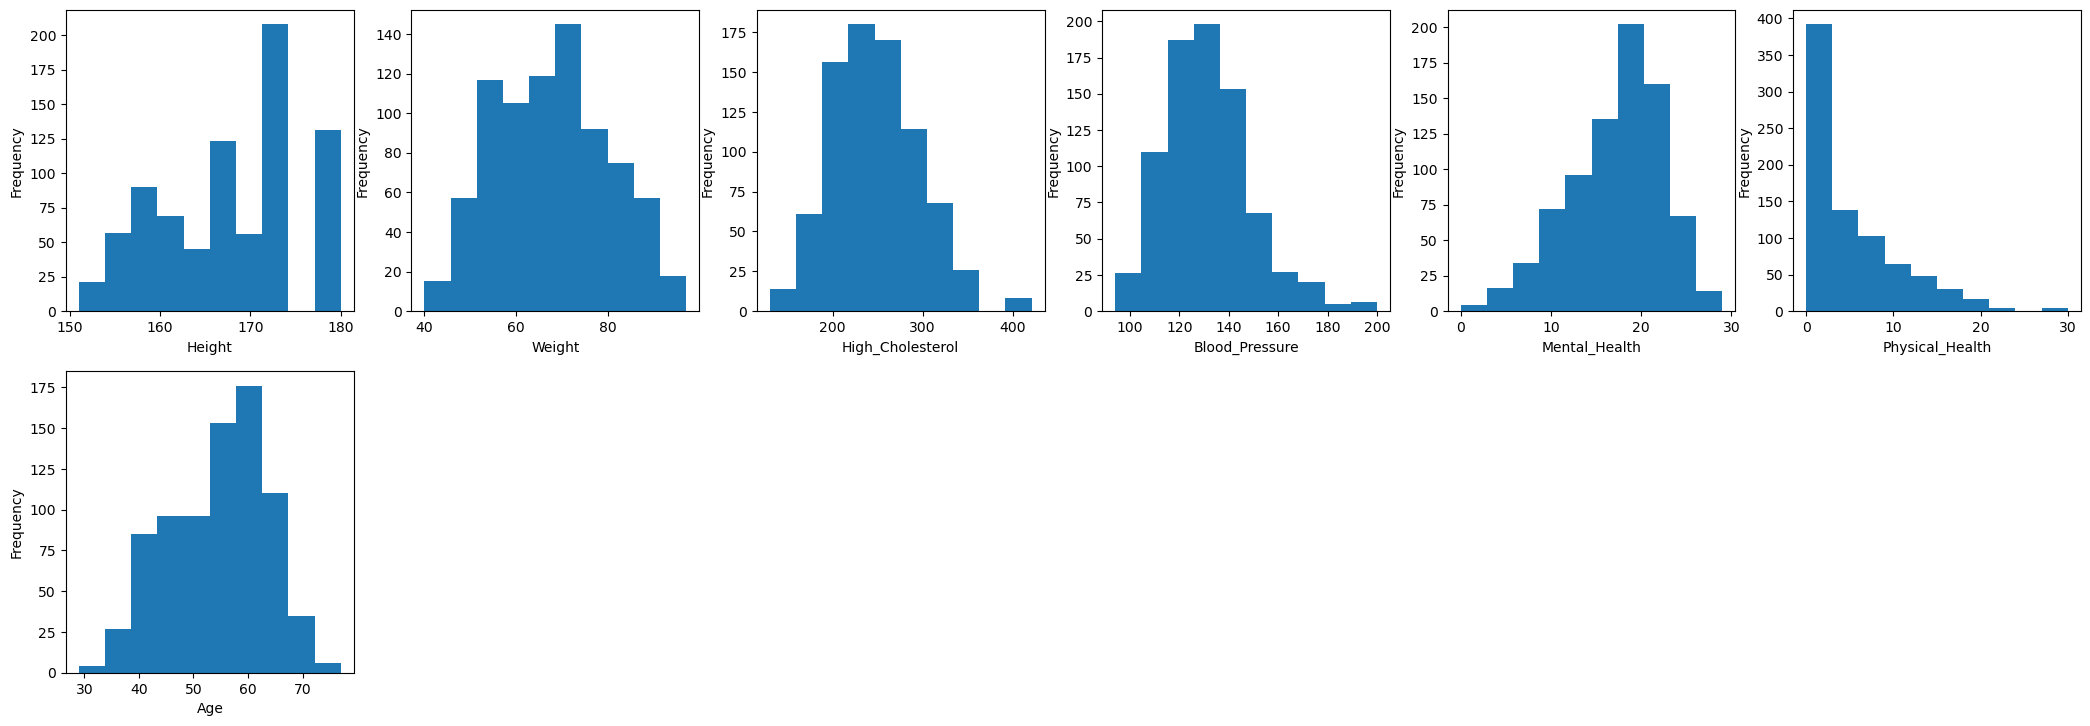

In [19]:
fig = plt.figure(figsize=(26, 18))  
i = 0
for column in num:
    sub = fig.add_subplot(4, 6 , i + 1)
    sub.set_xlabel(column)
    train_data[column].plot(kind = 'hist')
    i = i + 1

**Bar Charts - Binary Variables**

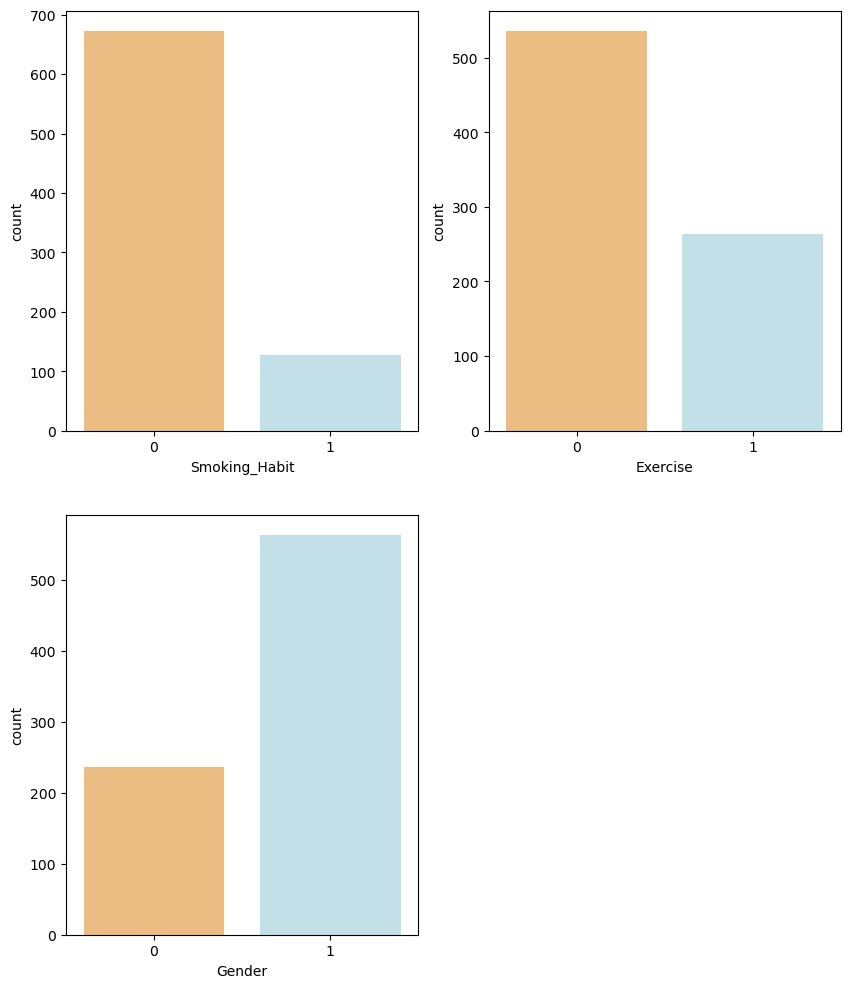

In [20]:
fig = plt.figure(figsize = (10,12))
i = 0
for i in range(len(bin_cat)):
    column = bin_cat[i]
    sub = fig.add_subplot(2,2,i+1)
    chart = sns.countplot(data=train_data,x = column, palette = 'RdYlBu')
    i = i + 1

**Bar Charts - Categorical Variables**

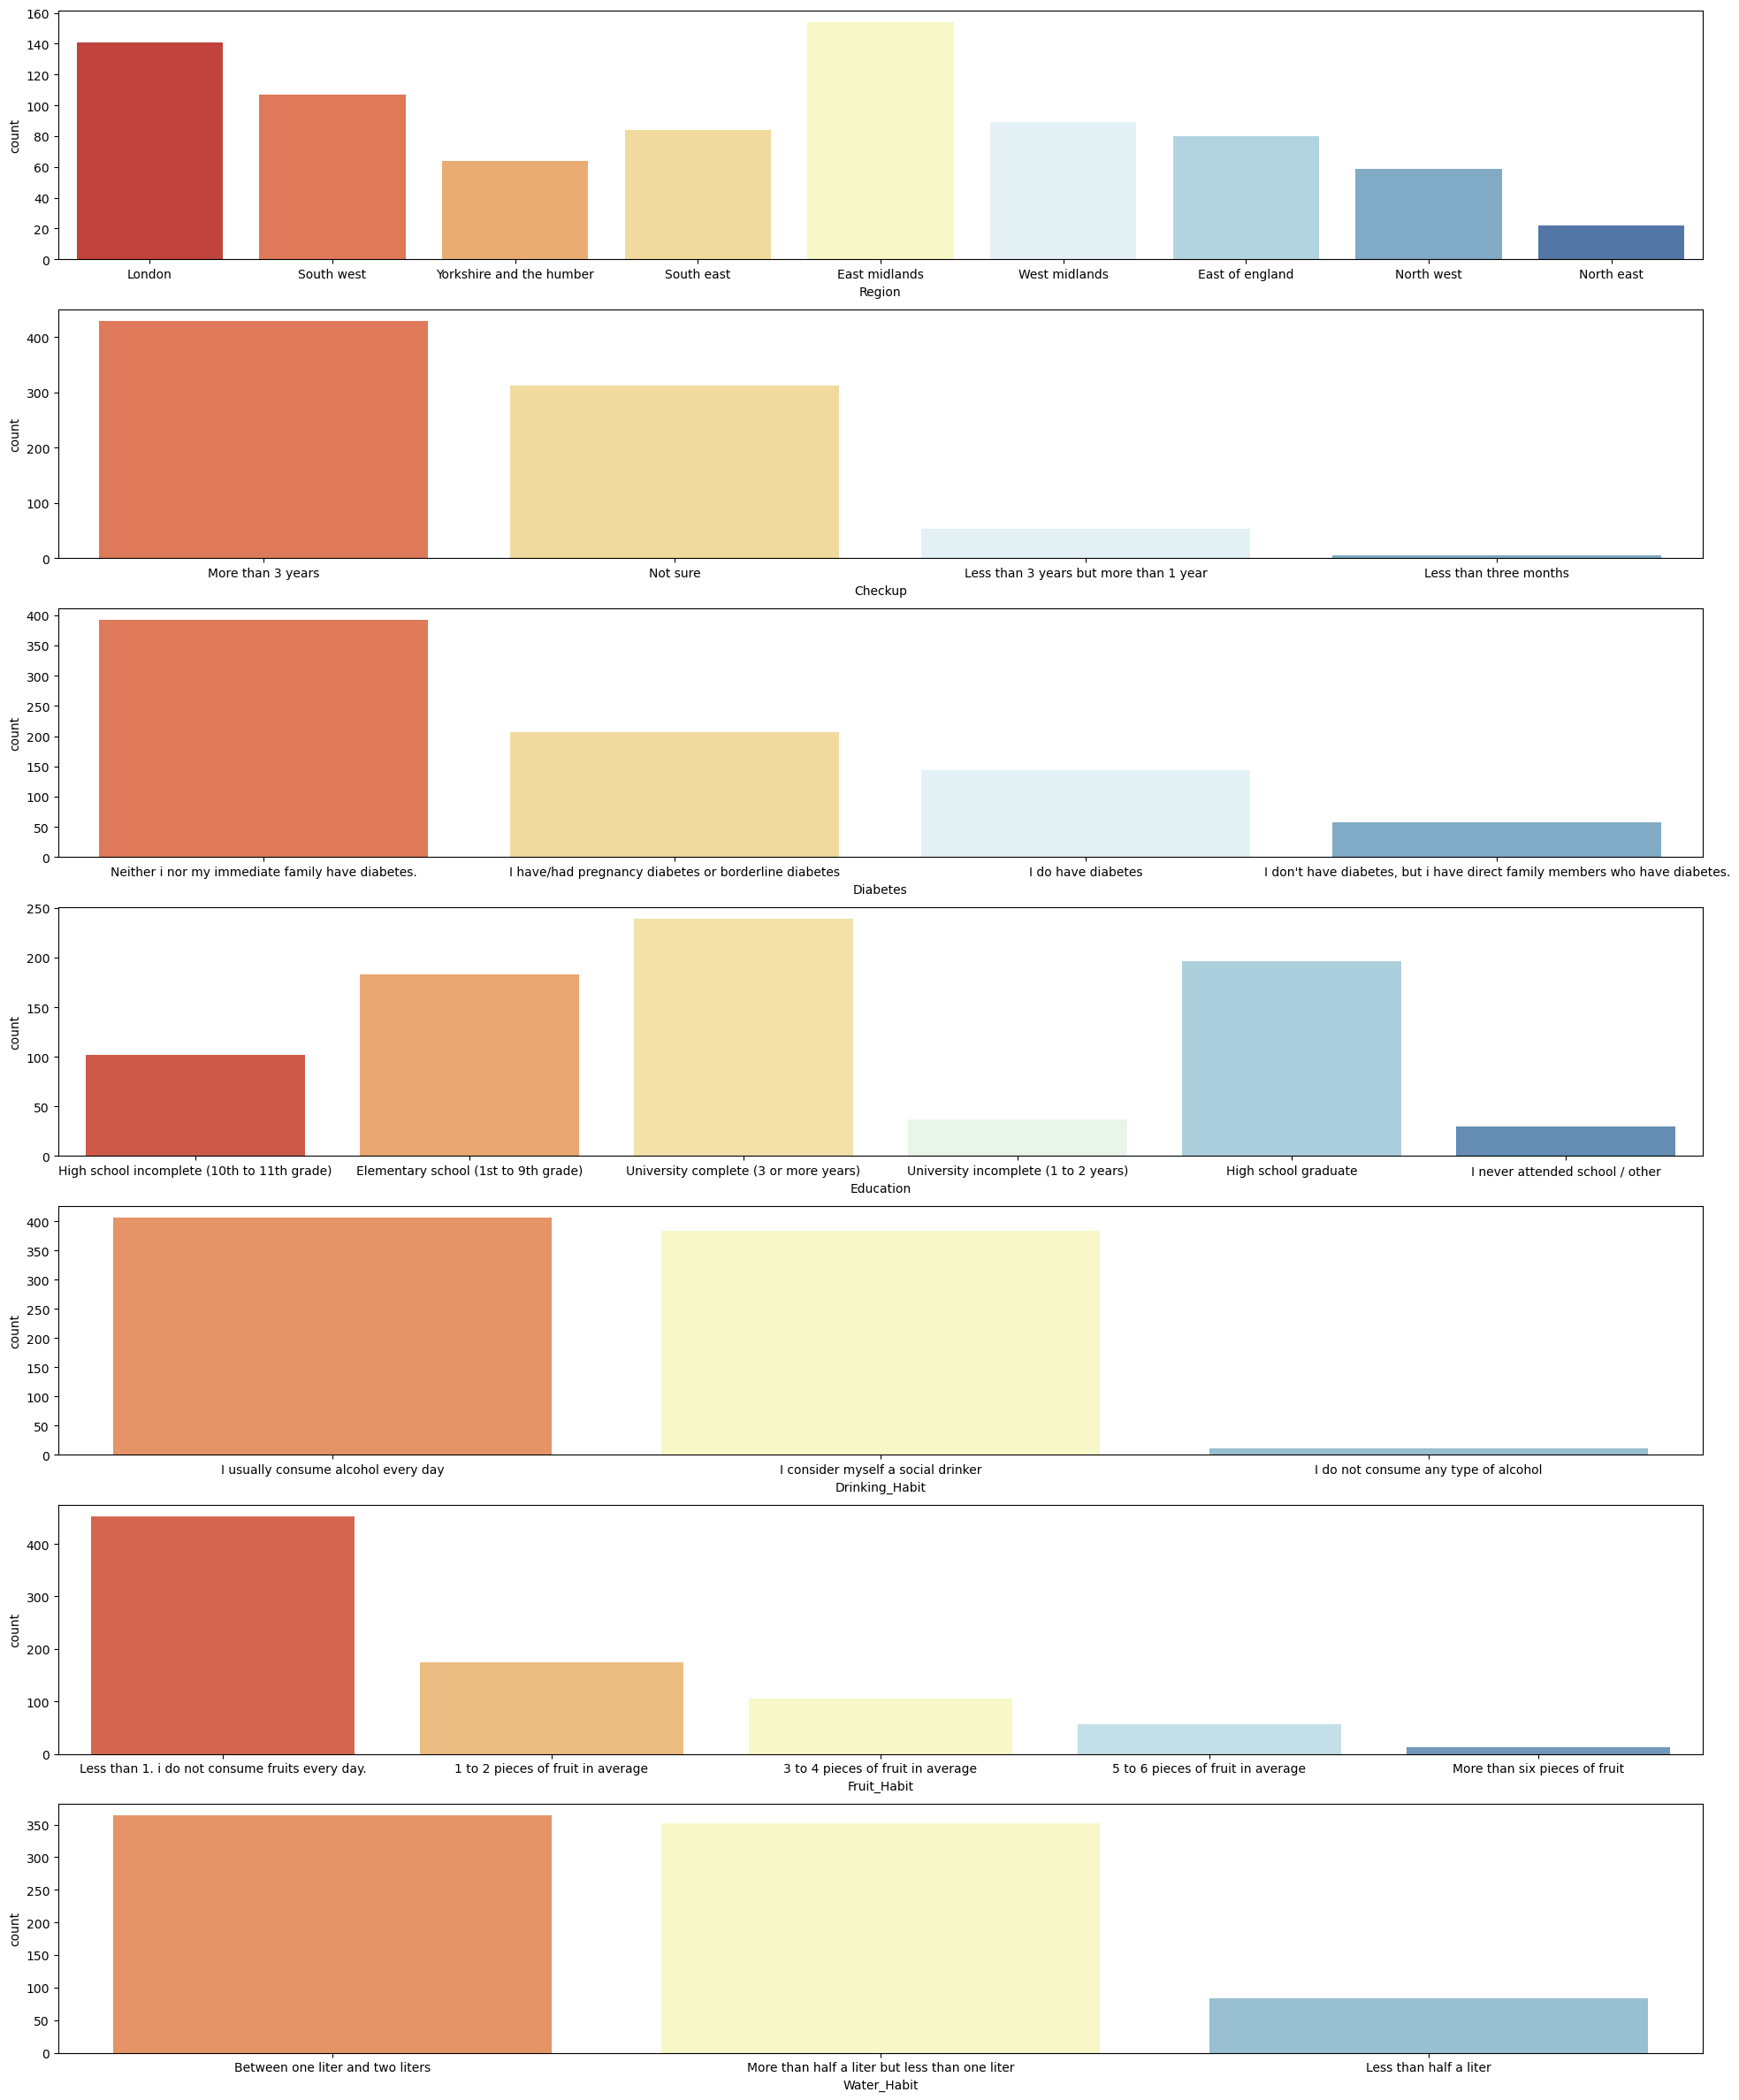

In [21]:
fig = plt.figure(figsize = (24,30))
i = 0
for i in range(len(cat)):
    column = cat[i]
    sub = fig.add_subplot(7,1,i+1)
    chart = sns.countplot(data=train_data,x = column, palette = 'RdYlBu')
    i = i + 1

### Multivariate Analysis

**Categorical Features vs Target**

>Grouped Bar Chart

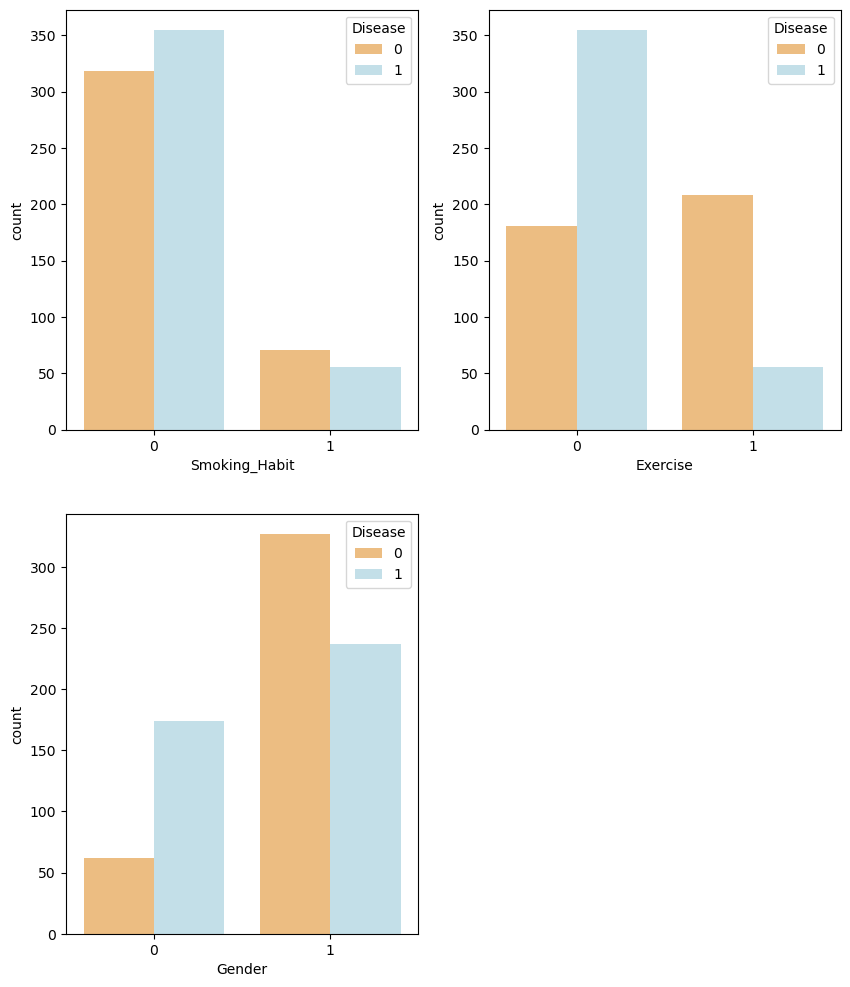

In [22]:
fig = plt.figure(figsize = (10,12))
i = 0
for i in range(len(bin_cat)):
    column = bin_cat[i]
    sub = fig.add_subplot(2,2,i+1)
    chart = sns.countplot(data=train_data,x = column, hue='Disease', palette = 'RdYlBu')
    i = i + 1

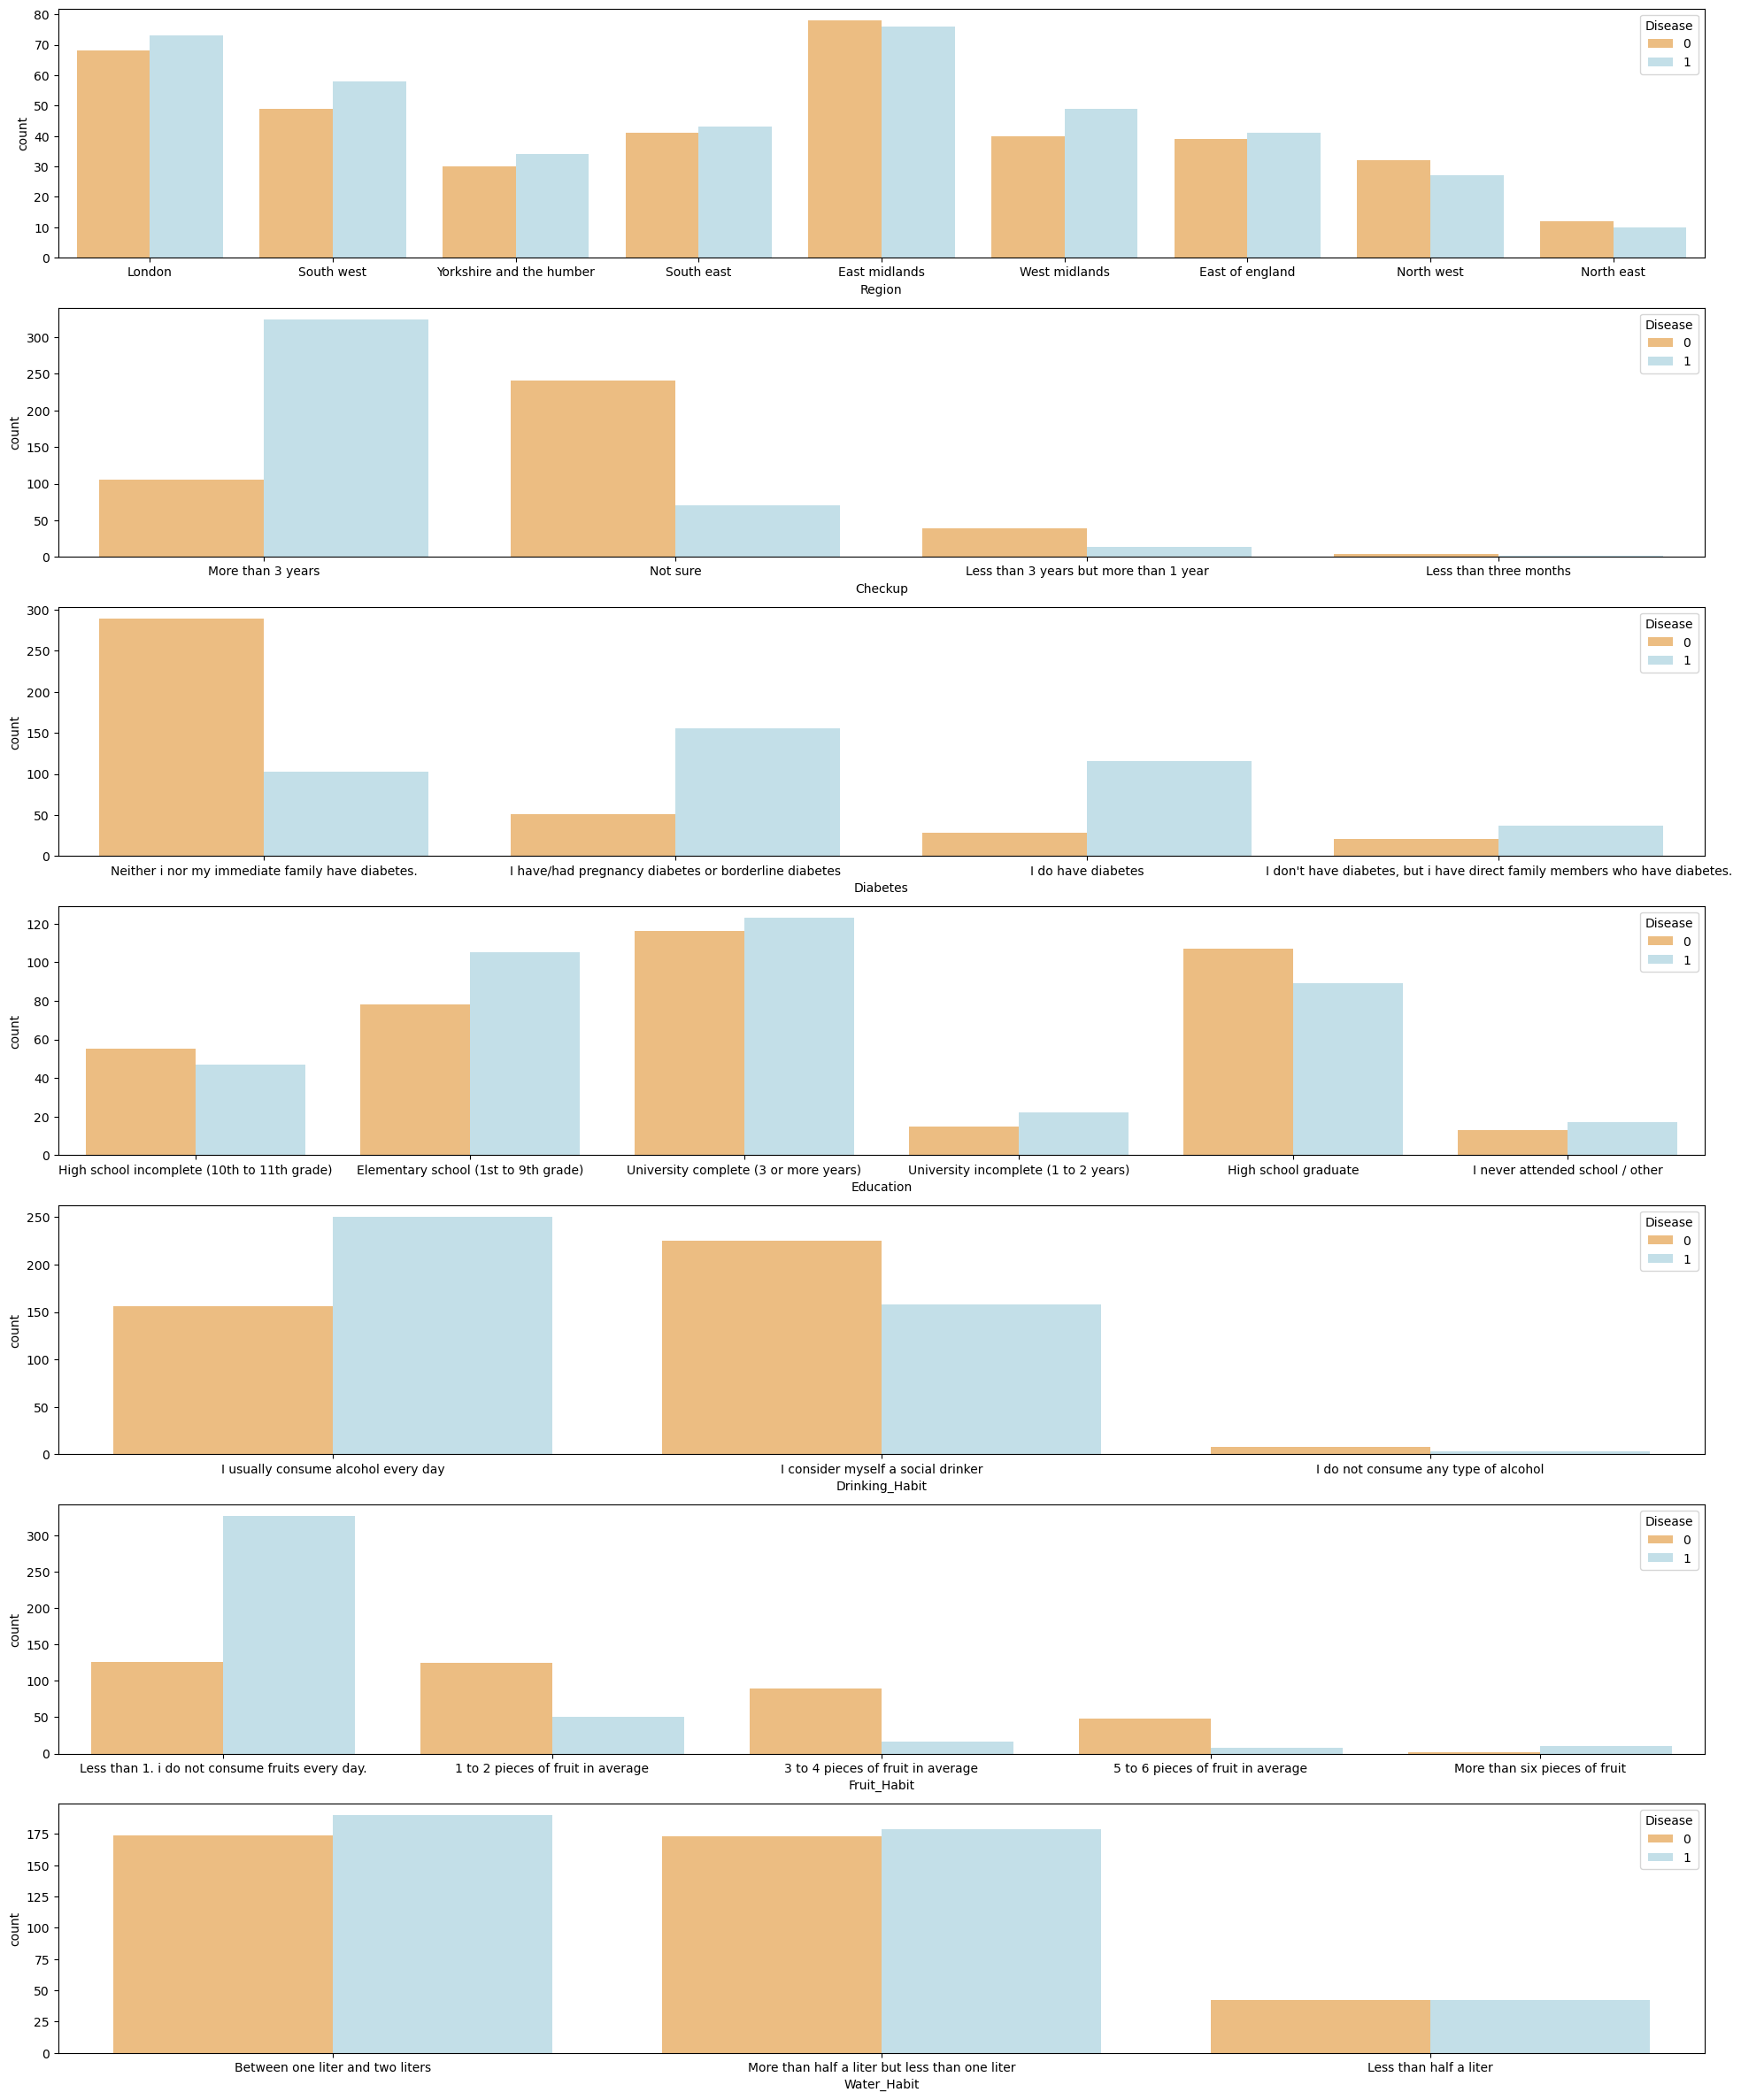

In [23]:
fig = plt.figure(figsize = (24,30))
i = 0
for i in range(len(cat)):
    column = cat[i]
    sub = fig.add_subplot(7,1,i+1)
    chart = sns.countplot(data=train_data,x = column, hue='Disease', palette = 'RdYlBu')
    i = i + 1

**Numerical Features vs Target**

>Box Plot

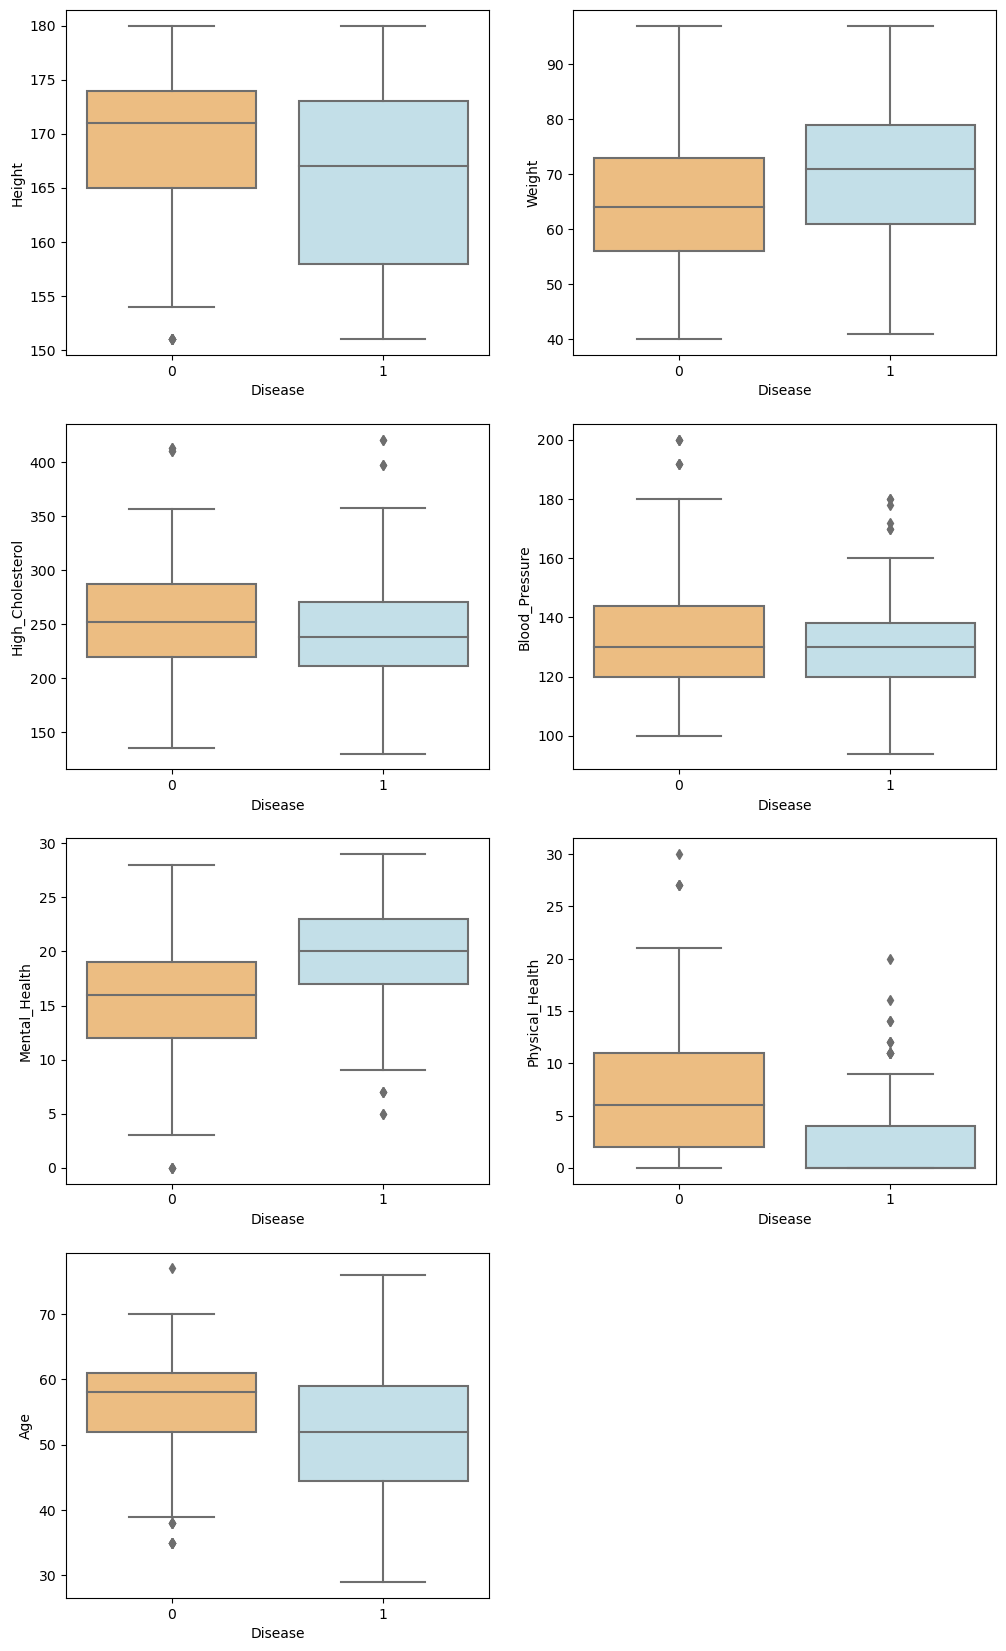

In [24]:
fig = plt.figure(figsize = (12,26))
for i in range(len(num)):
    column = num[i]
    sub = fig.add_subplot(5,2,i+1)
    chart = sns.boxplot(data=train_data, x='Disease', y = column, palette = 'RdYlBu')

<a class="anchor" id="topic04"> <br>
## Step 4 - Preprocessing


### Step 4.1 Handling Outliers

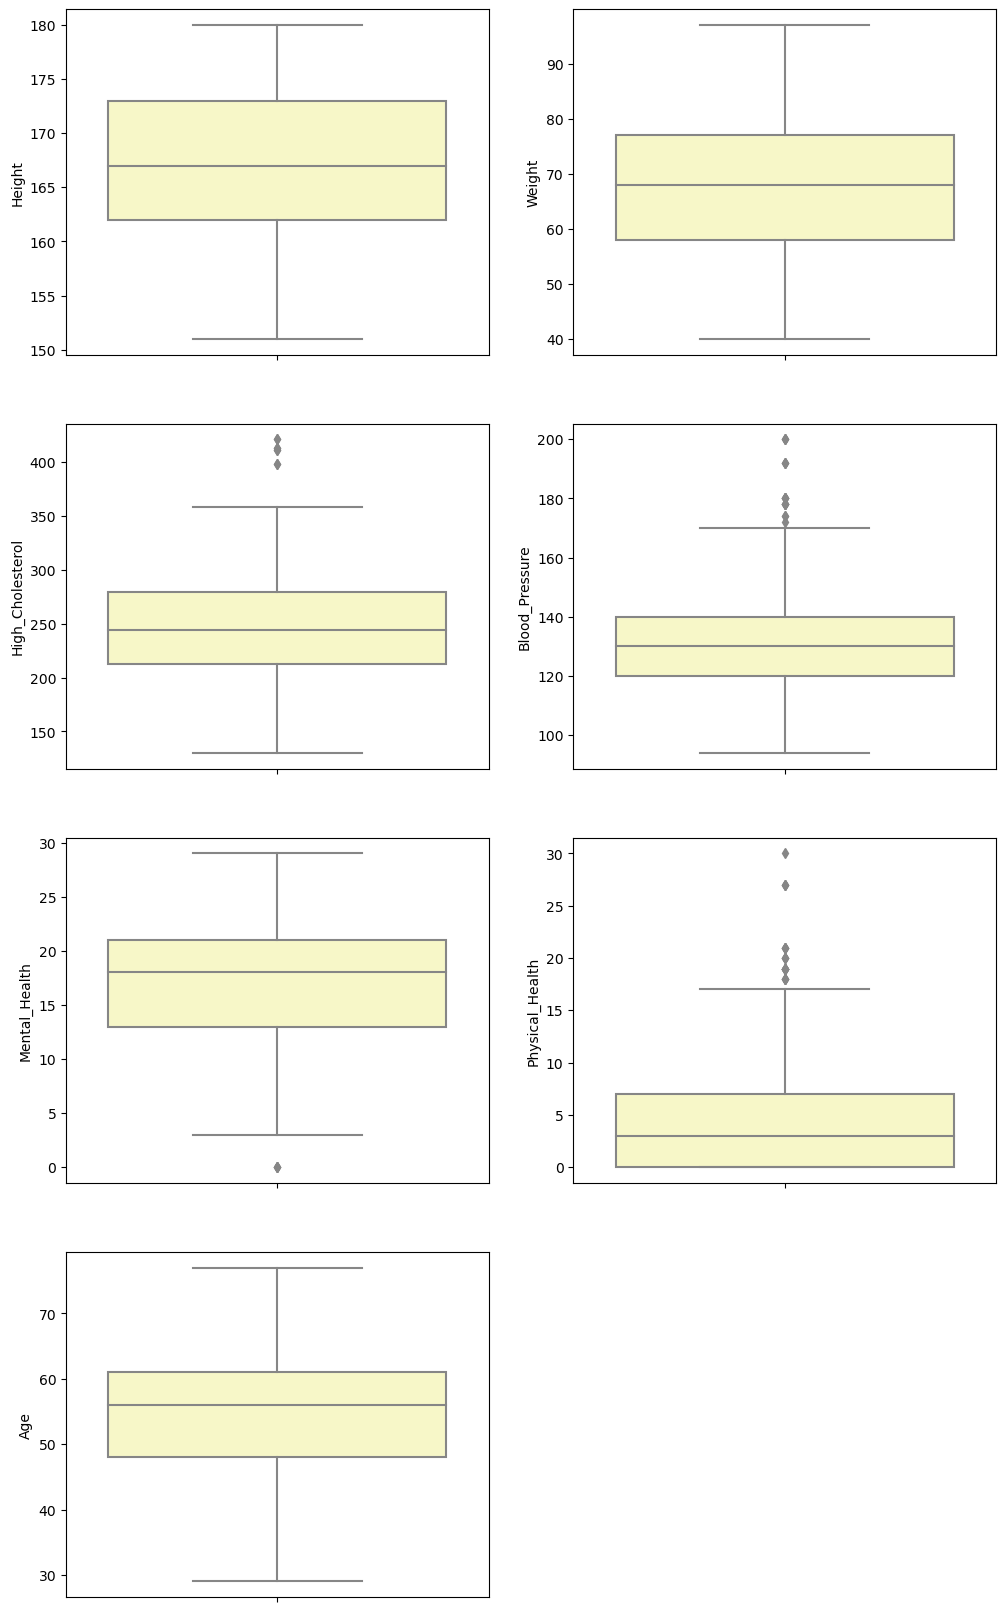

In [25]:
fig = plt.figure(figsize = (12,26))
for i in range(len(num)):
    column = num[i]
    sub = fig.add_subplot(5,2,i+1)
    chart = sns.boxplot(data=train_data, y = column, palette = 'RdYlBu')

**First approach:** Removing outliers from all numerical features

In [26]:
# usando o IQR
q25 = train_data.quantile(.25)
q75 = train_data.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters = []
for metric in num:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters.append(train_data[metric].between(llim, ulim, inclusive='both'))

test_outliers = train_data[np.all(filters, 0)]

In [27]:
print('Percentage of data kept after removing outliers:', np.round(test_outliers.shape[0] / train_data.shape[0], 4))

Percentage of data kept after removing outliers: 0.9225


**Final approach:** Removing outliers for significant numeric features so we don't lose as much data

In [28]:
# Using IQR for numerical variables that we considered significant ('Mental_Health','Physical_Health')

q25 = train_data.quantile(.25)
q75 = train_data.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters = []

update_num = ['Mental_Health','Physical_Health']

for metric in update_num:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters.append(train_data[metric].between(llim, ulim, inclusive='both'))

test_outliers = train_data[np.all(filters, 0)]

In [29]:
print('Percentage of data kept after removing outliers:', np.round(test_outliers.shape[0] / train_data.shape[0], 4))

Percentage of data kept after removing outliers: 0.9638


In [30]:
train_data = train_data[np.all(filters, 0)]

### Step 4.2 Train Test Split

In [31]:
data = train_data.drop(['Disease'], axis=1)
target = train_data['Disease']
X_train, X_val, y_train, y_val = train_test_split(data, 
                                                    target, 
                                                    test_size=0.30,
                                                    random_state=g_random_state, #seed
                                                    shuffle=True, 
                                                    stratify=target
                                                   )

### Step 4.3 Feature Selection for Categorical Variables

In [32]:
def get_independent_cats(X,target_var_name,alpha=0.05):        
    lst = []
    testindep_targ = X[target_var_name]
    testindep_data = X.drop([target_var_name], axis=1)

    for var in testindep_data:
        dfObserved = pd.crosstab(testindep_targ,testindep_data[var])
        chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
        dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
        if p<alpha:
            result="{0} is IMPORTANT for Prediction".format(var)
        else:
            lst.append(var)
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
        vprint(result)
    return lst

In [33]:
#Get categorical data + target variable
X_train_cat = X_train[cat]
X_train_cat['Disease'] = y_train
X_train_cat

dropcats = get_independent_cats(X_train_cat, "Disease")

# Drop independent features
X_train.drop(dropcats, axis=1, inplace=True)
X_val.drop(dropcats, axis=1, inplace=True)
data.drop(dropcats, axis=1, inplace=True)

# update the lists
non_ordinal_cat = [x for x in non_ordinal_cat if x not in dropcats]
ord_cat         = [x for x in ord_cat         if x not in dropcats]
bin_cat         = [x for x in bin_cat         if x not in dropcats]

cat = non_ordinal_cat + ord_cat

### Step 4.4 Feature Selection for Numerical Variables

__Multicollinearity__

Multicollinearity arises when there is a correlation between any two features. In machine learning, it is expected that each feature should be independent of others, i.e., there’s no colinearity between them.
In that sense, we want to remove features that are highly correlated with other explanatory variables.

<AxesSubplot:>

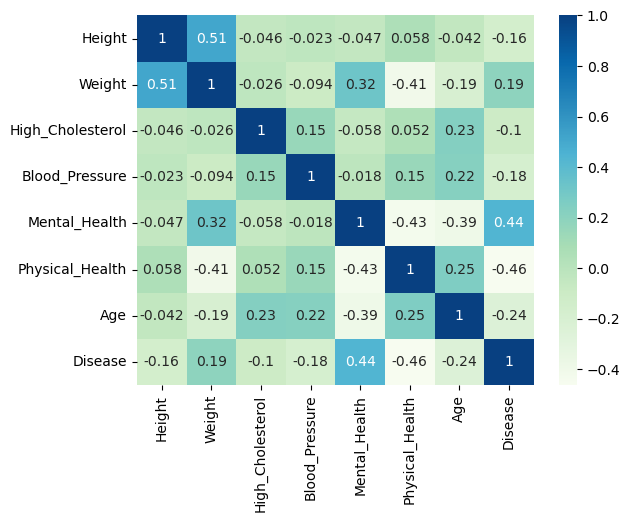

In [34]:
#correlation - X_train
X_train_num = X_train[num]
X_train_num['Disease'] = y_train
correlation = X_train_num.corr(method="spearman")
sns.heatmap(correlation, cmap = 'GnBu', annot = True)

The correlation doesn't seem particularly high for any set of features, so we have to take other approaches for feature selection.

__Low Variance__

If a feature has very low variance, it won't be useful for predicting our target variable. Therefore, we can drop these low-variance features.

In [35]:
# variance of numeric features
(X_train_num
 .select_dtypes(include=np.number)
 .var()
 .astype('str'))

Height                66.72376906152809
Weight               140.79360098213004
High_Cholesterol      2371.531380449006
Blood_Pressure        247.2504224400143
Mental_Health        28.926664413653334
Physical_Health       22.59647150512785
Age                   84.23350619418032
Disease             0.24940858398107485
dtype: object

None of the variables have particularly low variance.

__Uncorrelated features__ \
Features must be correlated with the target. If a feature does not exhibit a correlation, it is a prime target for elimination.

<AxesSubplot:>

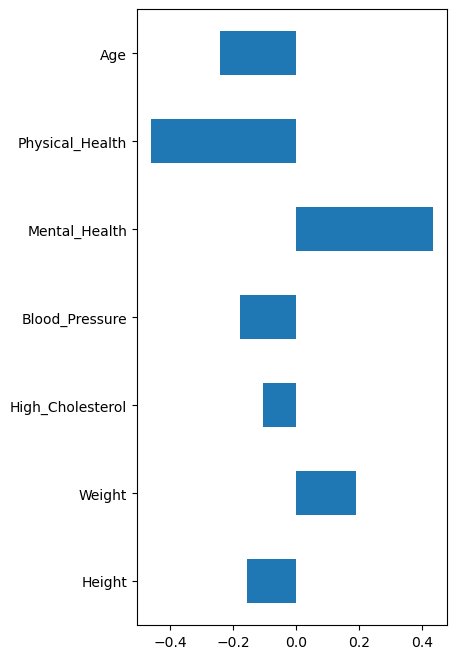

In [36]:
#correlation between target and features
plt.rcParams.update({'font.size': 10})
(X_train_num.corr(method="spearman").loc['Disease'].drop(['Disease'])
 .plot(kind='barh', figsize=(4,8)))

In [37]:
# drop uncorrelated numeric features (threshold <=0.25)
corr = abs(X_train_num.corr(method="spearman").loc['Disease'])
corr = corr[round(corr,2)<=0.25]
cols_to_drop = corr.index.to_list() 

In [38]:
cols_to_drop #features to drop

['Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure', 'Age']

__ANOVA__ 

In [39]:
# We used for testing with Anova our data without null values to double check our previous result
X_train_anova = X_train_num.dropna()
y_train_anova = X_train_anova['Disease']
X_train_anova.drop(['Disease'],inplace=True,axis=1)

fvalue_Best = SelectKBest(f_classif, k=2)
X_kbest = fvalue_Best.fit_transform(X_train_anova, y_train_anova)
print(X_kbest)

print('Original number of features:', X_train_num.shape)
print('Reduced number of features:', X_kbest.shape)

[[10.  4.]
 [25.  5.]
 [18.  0.]
 ...
 [20.  6.]
 [18.  0.]
 [13.  0.]]
Original number of features: (539, 8)
Reduced number of features: (534, 2)


In [40]:
cols = fvalue_Best.get_support(indices=True)
cols

array([4, 5])

In [41]:
X_train_anova.columns[cols] #features to keep

Index(['Mental_Health', 'Physical_Health'], dtype='object')

__Final Results: Numerical Variables to Drop__

After looking at various feature selection approaches, we can see that the conclusions are the same when using the ANOVA test and when checking which features are least correlated with the target variable. Therefore, we are only going to keep two numerical features: Mental_Health and Physical_Health.

In [42]:
X_train = X_train.drop(cols_to_drop, axis=1)
X_val = X_val.drop(cols_to_drop, axis=1)
data = data.drop(cols_to_drop, axis=1)
num = [x for x in num if x not in cols_to_drop]

<a class="anchor" id="topic05"> <br>
## Step 5 - Algorythm Chains: Pipelines and Column Transformers

Since early in the project we wanted to have a method to chain several steps, making sure that the output from one step worked consistently as input for the next step. The objective was that we could replace one part and all the rest would work seamlessly.
Professor Carina suggested that we looked into Pipelines form sklearn, and in fact they do precisely this.
By implementing a pipeline it is easier to move from one model to another without risking breaking the code.
Pipelines, as the name suggests, join different "pipes" and ensure that data flows from start to finish without leaks.
Instead of invoking methods for several features, such as Imputers, Encoders, Regressors, we assemble these elements in a pipeline, and then methods such as fit and transform are invoked at the pipeline level, hiding complexity and ensuring consistency.
Column Transformers create a simple flow where we can encode features using several encoders, after ensuring that null values are filled in using an inputer.

#### Bibliography: Introduction to Machine Learning with Python, Chapter 6, O'Reilly, Andreas C Muller, Sarah Guido


### 5.1 Pipeline, Column transformer

In [43]:
pipe_ordinals= Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('oe_ordinals', OrdinalEncoder(categories = [drink, fruit],handle_unknown='use_encoded_value', unknown_value = np.nan))
])

pipe_non_ordinal= Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe_checkup_diabetes', OneHotEncoder(sparse=False))   
])

pipe_num = Pipeline(steps=[
    ('num_scale',MinMaxScaler()),
    ('impute', KNNImputer())
])

pipe_bin = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent'))
])


col_trans = ColumnTransformer(transformers=[
    ('pipe_ordinals', pipe_ordinals,['Drinking_Habit', 'Fruit_Habit']),
     ('pipe_le_ohe', pipe_non_ordinal, non_ordinal_cat),
    ('pipe_num', pipe_num, num),
    ('pipe_bin', pipe_bin, bin_cat)
    ],
    n_jobs=-1)

### 5.2 Choosing a Base Model

In [44]:
model = RandomForestClassifier(random_state = g_random_state)

### 5.3 Pipeline, Assembling, running and presenting as a diagram

In [45]:
class Debug( TransformerMixin, BaseEstimator ):
        
    def transform(self, X):
        
        return X

    def fit(self, X, y=None, **fit_params):
        vprint(X.shape)
        vprint(pd.DataFrame(X).head(3))
        #print("fit_params:")
        #print(fit_params)
        
        return self

In [46]:
pipeline_rf = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', model)
])


# Display Pipeline
set_config(display='diagram')

#fit data
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('pipe_ordinals',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oe_ordinals',
                                                                   OrdinalEncoder(categories=[['I '
                                                                                               'do '
                                                                                               'not '
                                                                                               'consume '
                                                                                               'any '
                                                                                               'type '
                                                                                               'of '
                                                                                               'alcohol',
                                                                                               'I '
                                                                                               'consider '
                                                                                               'myself '
                                                                                               'a '
                                                                                               'social '
                                                                                               'drinker',
                                                                                               'I '
                                                                                               'usually '
                                                                                               'consume '
                                                                                               'alcohol '
                                                                                               'every '
                                                                                               'day'],
                                                                                              ['Less '
                                                                                               'than '
                                                                                               '1. '
                                                                                               'i '...
                                                                  ('ohe_checkup_diabetes',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Checkup', 'Diabetes']),
                                                 ('pipe_num',
                                                  Pipeline(steps=[('num_scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer())]),
                                                  ['Mental_Health',
                                                   'Physical_Health']),
                                                 ('pipe_bin',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Smoking_Habit',

<a class="anchor" id="topic06"> <br>
## Step 6 - Assessing several models with our data

In this step we are evaluating multiple models (using their default settings) in order to understand which models perform better with our data.

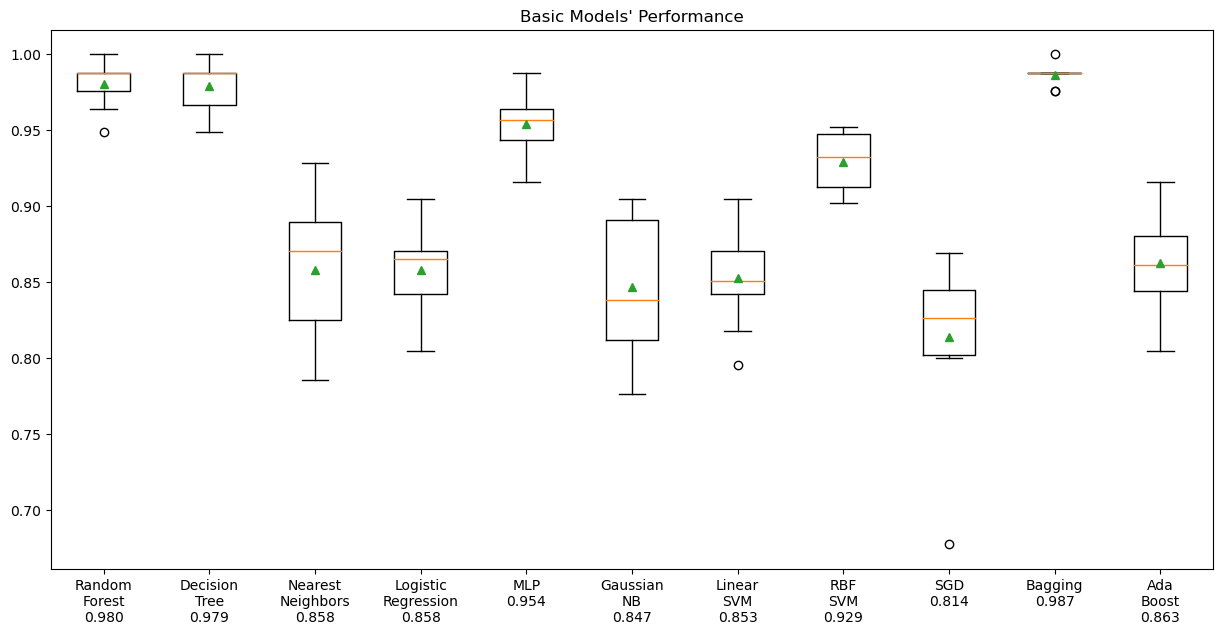

In [47]:
def get_default_models():
    models = dict()
    models["Random\nForest"] = Pipeline(steps=[('col_trans', col_trans), ('model', RandomForestClassifier(random_state = g_random_state))])
    models["Decision\nTree"] = Pipeline(steps=[('col_trans', col_trans), ('model', DecisionTreeClassifier(random_state = g_random_state))])
    models["Nearest\nNeighbors"] = Pipeline(steps=[('col_trans', col_trans), ('model', KNeighborsClassifier())])
    models["Logistic\nRegression"] = Pipeline(steps=[('col_trans', col_trans), ('model', LogisticRegression(random_state = g_random_state))])
    models["MLP"] = Pipeline(steps=[('col_trans', col_trans), ('model', MLPClassifier(max_iter=1000,random_state = g_random_state))])
    models["Gaussian\nNB"] = Pipeline(steps=[('col_trans', col_trans), ('model', GaussianNB())])
    models["Linear\nSVM"] = Pipeline(steps=[('col_trans', col_trans), ('model', SVC(kernel="linear",C=0.025,random_state = g_random_state))])
    models["RBF\nSVM"] = Pipeline(steps=[('col_trans', col_trans), ('model', SVC(gamma=2,C=1,random_state = g_random_state))])
    models["SGD"] = Pipeline(steps=[('col_trans', col_trans), ('model', SGDClassifier(random_state = g_random_state))])
    models["Bagging"] = Pipeline(steps=[('col_trans', col_trans), ('model', BaggingClassifier(random_state = g_random_state))])
    models["Ada\nBoost"] = Pipeline(steps=[('col_trans', col_trans), ('model', AdaBoostClassifier(random_state = g_random_state))])
    return models

models = get_default_models()
mx = myreturn_results(models, data, target, "Basic Models' Performance")

The models with better performances are:
- Random Forest
- Decision Tree
- Bagging
- Neural Networks

We will go into more detail about neural networks, random forests and, in the ensemble analysis, we will also look into Bagging.
Since Decision Trees are the building blocks of Random Forest and the default for Bagging, making it more prone to overfitting, we are not going to investigate further.

<a class="anchor" id="topic07"> <br>
## Step 7 - Optimized search for the ideal Hyperparameter : RandomForest()

### 7.1 Checking performance for train/validation data 
Checking the base model's performance for train and validation

In [48]:
predictions_train = pipeline_rf.predict(X_train)
predictions_val = pipeline_rf.predict(X_val)
print('Training set score: ' + str(f1_score(predictions_train,y_train)))
print('Validation set score: ' + str(f1_score(predictions_val,y_val)))

Training set score: 0.9982608695652174
Validation set score: 0.9473684210526316


### 7.2 Checking performance using cross-validation (KFold)
KFold performs several splits on the data, creating train and validation datasets, and then
evaluates the model performance for train/validation and returns the averaged result.
This makes the performance evaluation less dependent on the actual data split that was performed.

As KFold already splits data, we are using all data, not the separate train and validation splits. This would result in only the train data being actually used.


In [49]:
avg_score(cv, data, target, pipeline_rf)

Train average score:0.997+/-0.001
Val average score:0.98+/-0.014
Overfitting abs(Train-Val):0.016


### 7.3 Evaluating each hyperparameter one by one

#### criterion (default = 'gini')
The function to measure the quality of a split. \
Supported criteria are “gini”, for the Gini impurity, and “log_loss” and “entropy”, both for the Shannon information gain.

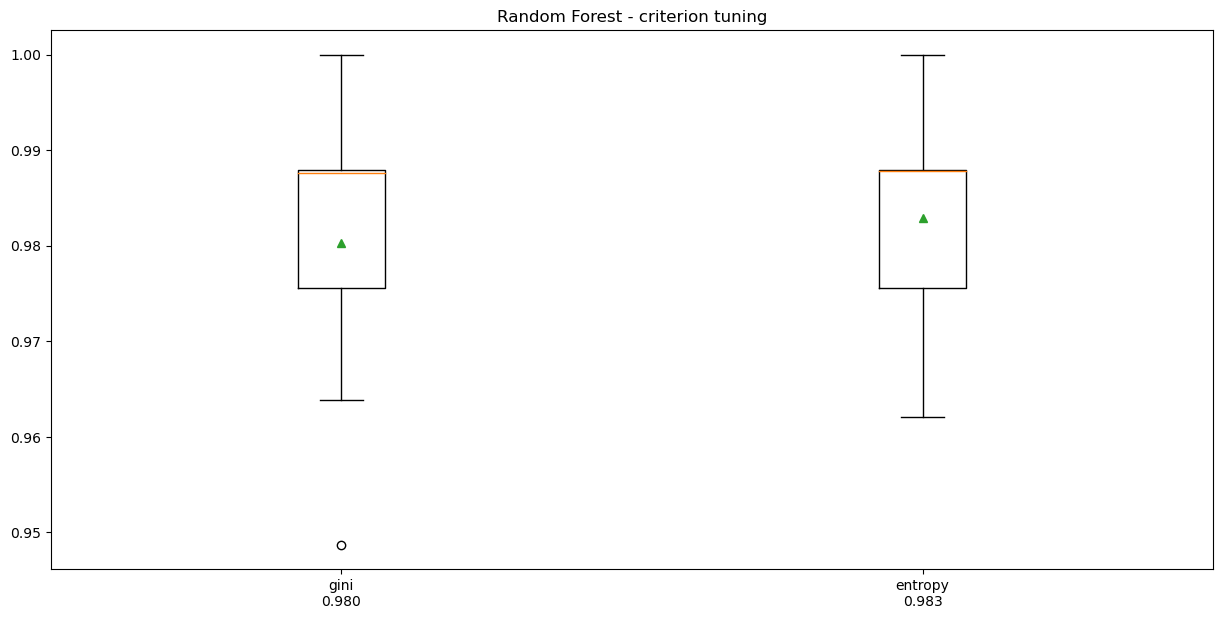

In [50]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', RandomForestClassifier(criterion = value, random_state = g_random_state))])   
    return models

models = get_models(['gini', 'entropy'])
mx = myreturn_results(models, data, target, 'Random Forest - criterion tuning')

It looks like 'gini' and 'entropy' give us simillar results.

#### min_samples_leaf (default = 1)
The minimum number of samples required to be at a leaf node. \
A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.\
- If int, then consider min_samples_leaf as the minimum number.
- If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.

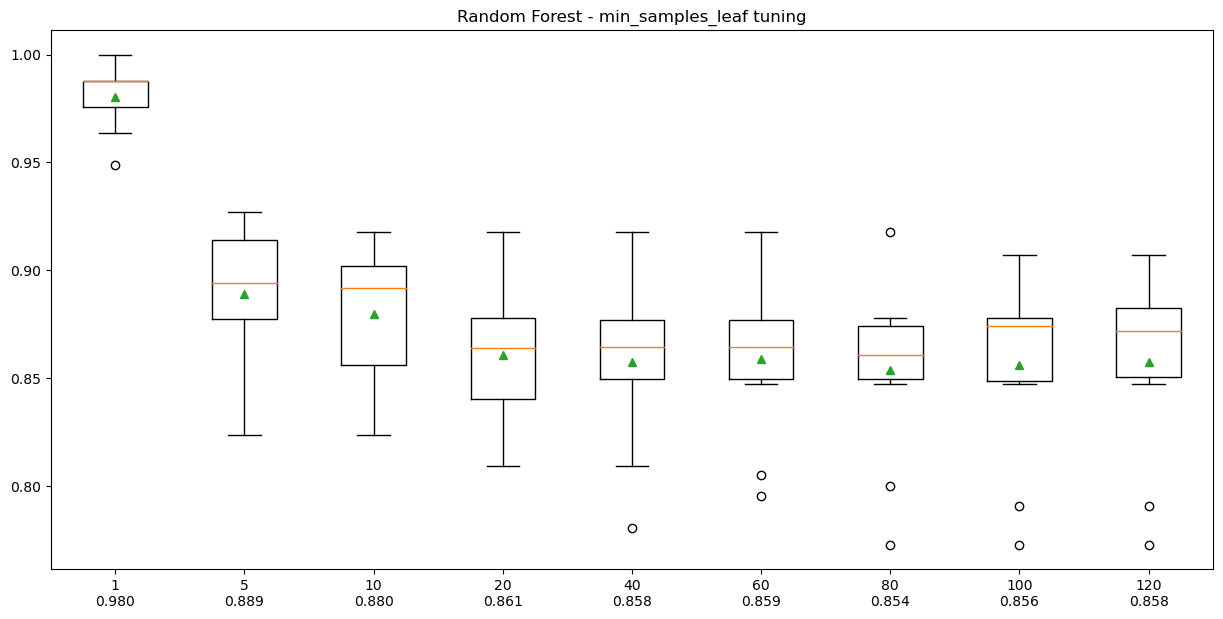

In [51]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', RandomForestClassifier(min_samples_leaf = value  , random_state = g_random_state))])   
    return models

models = get_models([1, 5, 10, 20, 40, 60, 80, 100, 120])
mx = myreturn_results(models, data, target, 'Random Forest - min_samples_leaf tuning')

We get better results with a smaller number of min_samples_leaf.

#### max_leaf_nodes (default = None)
Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity.\
If None then unlimited number of leaf nodes.

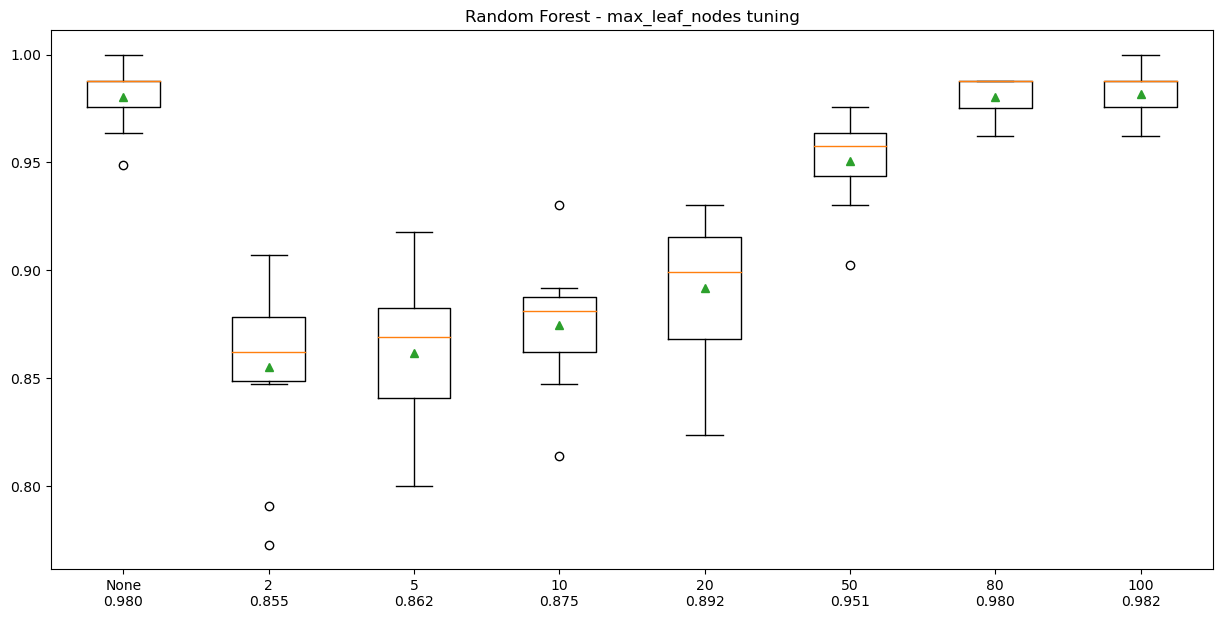

In [52]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', RandomForestClassifier(max_leaf_nodes = value  , random_state = g_random_state))])   
    return models

models = get_models([None, 2, 5,10, 20, 50, 80, 100])
mx = myreturn_results(models, data, target, 'Random Forest - max_leaf_nodes tuning')

The f1 score is better for max_leaf_nodes set to None or to higher values (bigger than 50).

#### max_features (default = 'sqrt')
The number of features to consider when looking for the best split:
- If int, then consider max_features features at each split.
- If float, then max_features is a fraction and max(1, int(max_features * n_features_in_)) features are considered at each split.
- If “auto”, then max_features=sqrt(n_features).
- If “sqrt”, then max_features=sqrt(n_features).
- If “log2”, then max_features=log2(n_features).
- If None, then max_features=n_features.

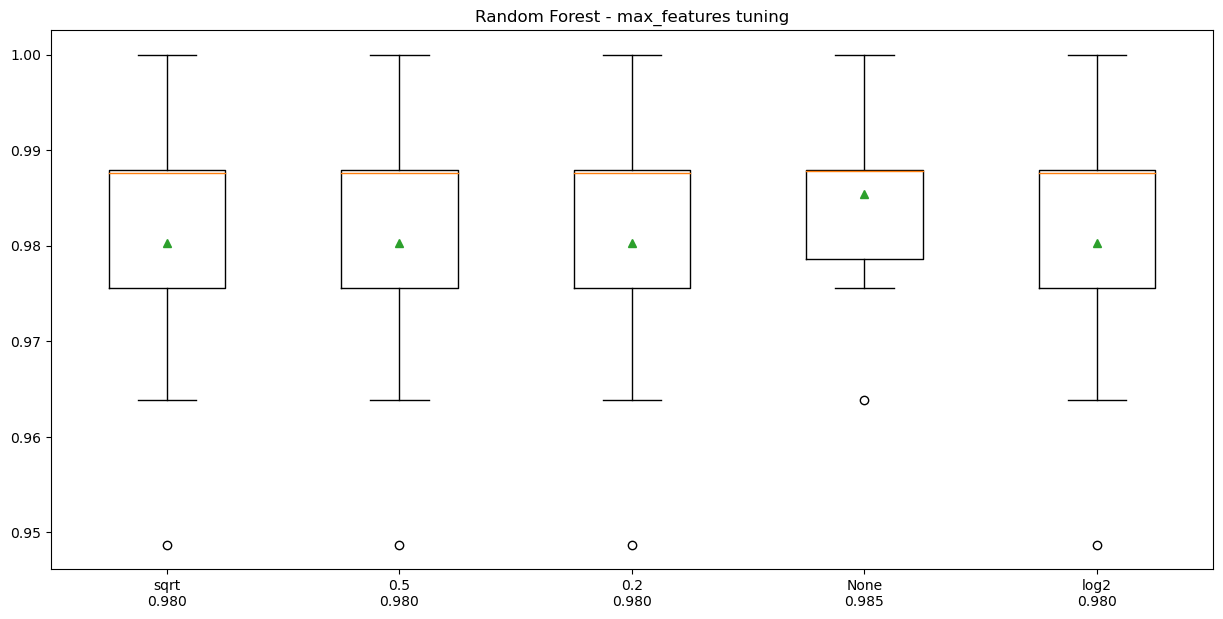

In [53]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', RandomForestClassifier(max_features = value  , random_state = g_random_state))])   
    return models

models = get_models(['sqrt', 0.5,0.2,None, 'log2'])
mx = myreturn_results(models, data, target, 'Random Forest - max_features tuning')

They all give us similar results.

#### n_estimators (default = 100)
The number of trees in the forest.

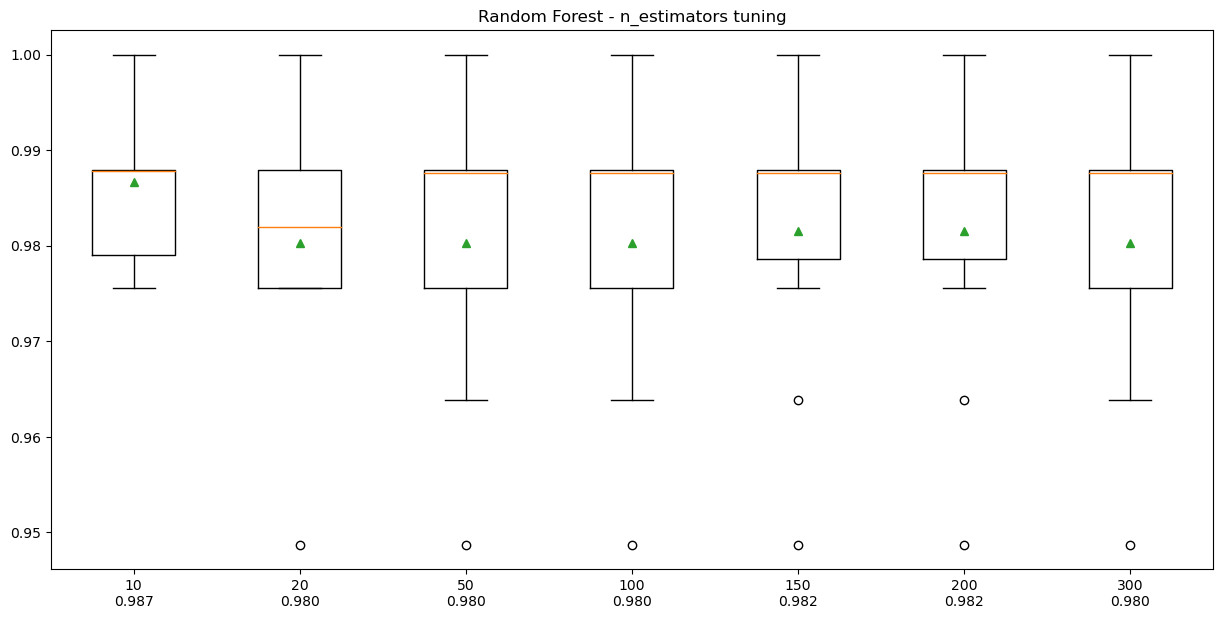

In [54]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', RandomForestClassifier(n_estimators = value, random_state = g_random_state))])   
    return models

models = get_models([10,20,50,100,150,200,300])
mx = myreturn_results(models, data, target, 'Random Forest - n_estimators tuning')

The scores are quite similar but they generally increase when there are more estimators.

#### bootstrap (default = True)
Whether bootstrap samples are used when building trees. \
If False, the whole dataset is used to build each tree.

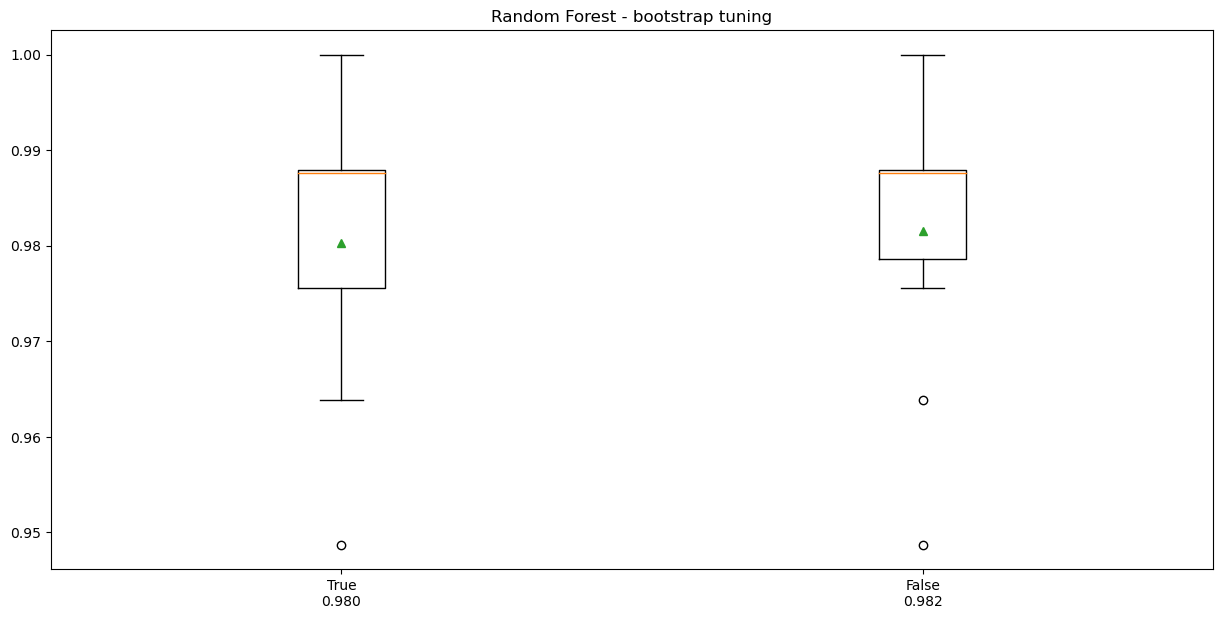

In [55]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', RandomForestClassifier(bootstrap = value, random_state = g_random_state))])   
    return models

models = get_models([True, False])
mx = myreturn_results(models, data, target, 'Random Forest - bootstrap tuning')

They give us similar f1 scores. However, choosing bootstrap=False can more likely lead to overfitting.

#### max_samples (default = None)
- If bootstrap is True, the number of samples to draw from X to train each base estimator.
- If None (default), then draw X.shape[0] samples.
- If int, then draw max_samples samples.
- If float, then draw max_samples * X.shape[0] samples. Thus, max_samples should be in the interval (0.0, 1.0].



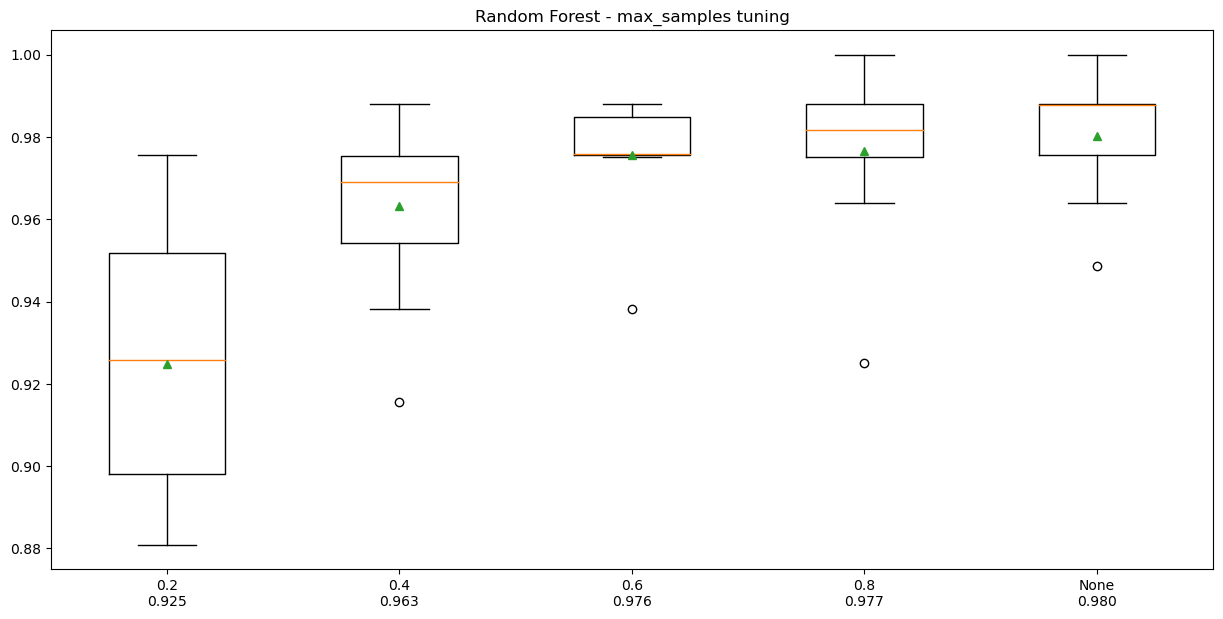

In [56]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', RandomForestClassifier(max_samples = value, random_state = g_random_state))])   
    return models

models = get_models([0.2,0.4,0.6,0.8,None])
mx = myreturn_results(models, data, target, 'Random Forest - max_samples tuning')

The f1 score seems to increase as max_samples increases and we get the biggest value for max_samples set to 0.6 or 0.8.

#### max_depth (default = None)
The maximum depth of the tree. \
If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

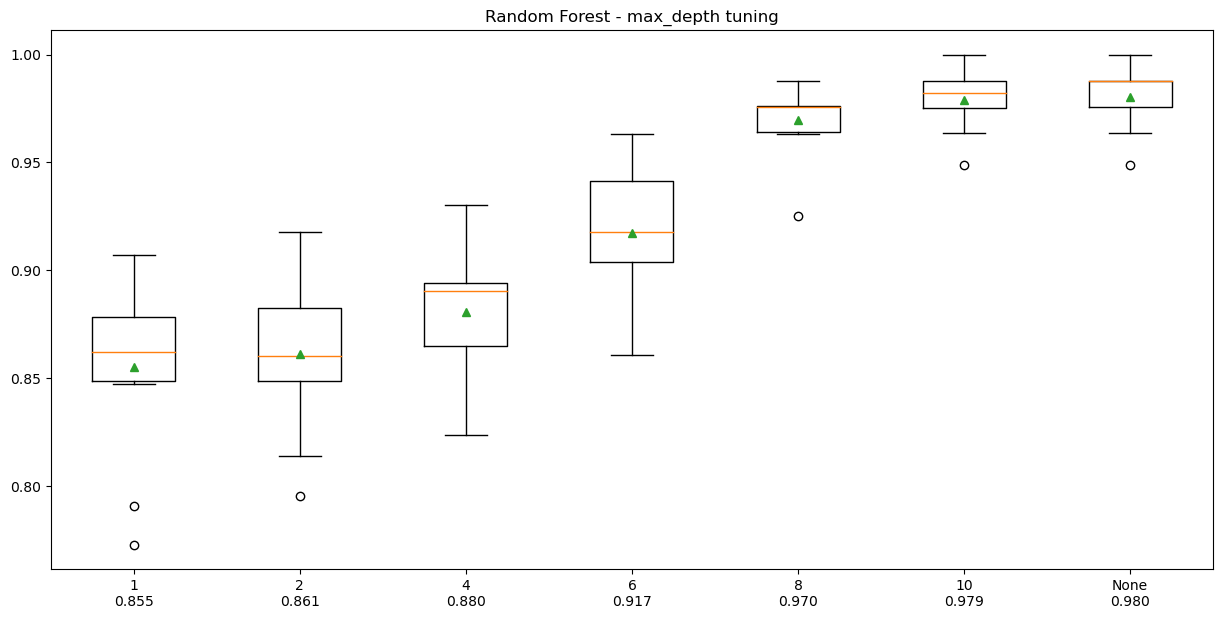

In [57]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', RandomForestClassifier(max_depth = value, random_state = g_random_state))])   
    return models

models = get_models([1,2,4,6,8,10,None])
mx = myreturn_results(models, data, target, 'Random Forest - max_depth tuning')

f1 score increases when the max_depth gets higher and it's also quite big for max_depth=None.

### 7.4 Use RandomizedSearchCV to get good ballpark values for hyperparameters

In [58]:
#Defining the parameter space in which to search for the best random forest model
param_space_broad = {
    'model__max_depth': [None] + list(range(5, 20)), ## 
    'model__criterion': ['gini', 'entropy'],
    'model__n_estimators':  range(1,200,25), ## 
    'model__min_samples_leaf':[1, 2, 3, 4, 5],
    'model__max_features': ['sqrt', 0.5,0.2, None, 'log2'],
    'model__max_leaf_nodes': [None] + list(range(80, 100, 5)),
    'model__bootstrap': [True], # default, Not the best individually but reduces overfitting (smaller variance)
    'model__max_samples': [None, 0.6, 0.7, 0.8, 0.9, 1]
    }

randsearch = RandomizedSearchCV(pipeline_rf, param_space_broad, n_iter=100, scoring='f1', n_jobs=-1, random_state= g_random_state)

In [59]:
randsearch.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('col_trans',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('pipe_ordinals',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('oe_ordinals',
                                                                                                OrdinalEncoder(categories=[['I '
                                                                                                                            'do '
                                                                                                                            'not '
                                                                                                                            'consume '
                                                                                                                            'any '
                                                                                                                            'type '
                                                                                                                            'of '
                                                                                                                            'alcohol',
                                                                                                                            'I '
                                                                                                                            'consider '
                                                                                                                            'myself '
                                                                                                                            'a '
                                                                                                                            'social '
                                                                                                                            'drinker',
                                                                                                                            'I '
                                                                                                                            'usually '
                                                                                                                            'consume '
                                                                                                                            'alcohol '
                                                                                                                            'ever...
                                        'model__criterion': ['gini', 'entropy'],
                                        'model__max_depth': [None, 5, 6, 7, 8,
                                                             9, 10, 11, 12, 13,
                                                             14, 15, 16, 17, 18,
                                                             19],
                                        'model__max_features': ['sqrt', 0.5,
                                                                0.2, None,
                                                                'log2'],
                                        'model__max_leaf_nodes': [None, 80, 85,
                                                                  90, 95],
                                        'model__max_samples': [None, 0.6, 0.7,
                                                    

In [60]:
randsearch.best_params_

{'model__n_estimators': 51,
 'model__min_samples_leaf': 1,
 'model__max_samples': 0.8,
 'model__max_leaf_nodes': 90,
 'model__max_features': 0.2,
 'model__max_depth': 14,
 'model__criterion': 'gini',
 'model__bootstrap': True}

### 7.5 GridSearchCV using the approximate values found in the previous step, fine-tune the Hyperparameters

In [61]:
np.arange( round(randsearch.best_params_['model__max_samples']-0.1,2), round(min(1, randsearch.best_params_['model__max_samples']+0.1),2),0.1)

array([0.7, 0.8, 0.9])

In [62]:
# range__max_depth
if randsearch.best_params_['model__max_depth'] == None:
    range__max_depth = [None] + list(range(5, 20,5))
else:
    range__max_depth = range(max(1, randsearch.best_params_['model__max_depth']-2),randsearch.best_params_['model__max_depth']+2,2)

# range__n_estimators
if randsearch.best_params_['model__n_estimators'] == None:
    range__n_estimators = [None] + list(range(1,200,50))
else:
    range__n_estimators = range(max(1,randsearch.best_params_['model__n_estimators']-5),randsearch.best_params_['model__n_estimators']+5,5)

# range__min_samples_leaf
if randsearch.best_params_['model__min_samples_leaf'] == None:
    range__min_samples_leaf = [None] + list( range(1,5,2))
else:
    range__min_samples_leaf = range( max(1, randsearch.best_params_['model__min_samples_leaf']-5),randsearch.best_params_['model__min_samples_leaf']+5,5)


# range__model_max_features
if (randsearch.best_params_['model__max_features'] == None) or (randsearch.best_params_['model__max_features'] == 'sqrt') or (randsearch.best_params_['model__max_features'] == 'log2'):
    range__model_max_features = [None, 'sqrt', 'log2',0.5, 0.2]
else:
    range__model_max_features = np.round_(np.arange( randsearch.best_params_['model__max_features']-0.1, min(1, randsearch.best_params_['model__max_features']+0.1),0.1),2)

    
# range__model_max_samples
if randsearch.best_params_['model__max_samples'] == None:
    range__max_samples = [None, 0.6, 0.8, 1]
else:                                            
    range__max_samples = np.round_(np.arange( randsearch.best_params_['model__max_samples']-0.1, min(1, randsearch.best_params_['model__max_samples']+0.1),0.1),2)

# range__model_max_leaf_nodes
if randsearch.best_params_['model__max_leaf_nodes'] == None:
    range__max_leaf_nodes = [None] + list(range(80, 100, 10))
else:
    range__max_leaf_nodes = range( max(1, randsearch.best_params_['model__max_leaf_nodes']-5),randsearch.best_params_['model__max_leaf_nodes']+5,5)


#Defining the parameter space to use in order to fine tune our previous best random forest model
param_space_fine_tune = {
    'model__max_depth': range__max_depth,
    'model__criterion': [randsearch.best_params_['model__criterion']],
    'model__n_estimators': range__n_estimators,
    'model__min_samples_leaf': range__min_samples_leaf,
    'model__max_features': range__model_max_features,
    'model__max_samples': range__max_samples,
    'model__max_leaf_nodes': range__max_leaf_nodes
}

gridsearch = GridSearchCV(pipeline_rf, param_space_fine_tune, scoring = 'f1', return_train_score = True)

In [63]:
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('pipe_ordinals',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('oe_ordinals',
                                                                                          OrdinalEncoder(categories=[['I '
                                                                                                                      'do '
                                                                                                                      'not '
                                                                                                                      'consume '
                                                                                                                      'any '
                                                                                                                      'type '
                                                                                                                      'of '
                                                                                                                      'alcohol',
                                                                                                                      'I '
                                                                                                                      'consider '
                                                                                                                      'myself '
                                                                                                                      'a '
                                                                                                                      'social '
                                                                                                                      'drinker',
                                                                                                                      'I '
                                                                                                                      'usually '
                                                                                                                      'consume '
                                                                                                                      'alcohol '
                                                                                                                      'every '
                                                                                                                      'day...
                                        RandomForestClassifier(random_state=53))]),
             param_grid={'model__criterion': ['gini'],
                         'model__max_depth': range(12, 16, 2),
                         'model__max_features': array([0.1, 0.2, 0.3]),
                         'model__max_leaf_nodes': range(85, 95, 5),
                         'model__max_samples': array([0.7, 0.8]),
                         'model__min_samples_leaf': range(1, 6, 5),
                         'model__n_estimators': range(46, 56, 5)},
             return_train_score=True, scoring='f1')

In [64]:
gridsearch.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 14,
 'model__max_features': 0.2,
 'model__max_leaf_nodes': 85,
 'model__max_samples': 0.8,
 'model__min_samples_leaf': 1,
 'model__n_estimators': 51}

### 7.6 Best Parameters for our model

In [65]:
print("Best parameters using RandomizedSearchCV\n{}".format( randsearch.best_params_))
print("Best parameters using GridSearchCV\n{}".format( gridsearch.best_params_))

Best parameters using RandomizedSearchCV
{'model__n_estimators': 51, 'model__min_samples_leaf': 1, 'model__max_samples': 0.8, 'model__max_leaf_nodes': 90, 'model__max_features': 0.2, 'model__max_depth': 14, 'model__criterion': 'gini', 'model__bootstrap': True}
Best parameters using GridSearchCV
{'model__criterion': 'gini', 'model__max_depth': 14, 'model__max_features': 0.2, 'model__max_leaf_nodes': 85, 'model__max_samples': 0.8, 'model__min_samples_leaf': 1, 'model__n_estimators': 51}


In [66]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', gridsearch.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = gridsearch.cv_results_['mean_test_score']
stds = gridsearch.cv_results_['std_test_score']
mean_trains = gridsearch.cv_results_['mean_train_score']
params = gridsearch.cv_results_['params']

results = pd.DataFrame(zip(means, stds, mean_trains, params), columns=['Mean Val','Std','Mean Train','Params'])
results.sort_values(by=['Mean Val'], inplace = True, ascending = False)
results

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'model__criterion': 'gini', 'model__max_depth': 14, 'model__max_features': 0.2, 'model__max_leaf_nodes': 85, 'model__max_samples': 0.8, 'model__min_samples_leaf': 1, 'model__n_estimators': 51}
------------------------------------------------------------------------------------------------------------------------


,Mean Val,Std,Mean Train,Params
39,0.960584,0.010006,0.998259,"{'model__criterion': 'gini', 'model__max_depth..."
35,0.960584,0.010006,0.998259,"{'model__criterion': 'gini', 'model__max_depth..."
34,0.958752,0.009884,0.997825,"{'model__criterion': 'gini', 'model__max_depth..."
38,0.958752,0.009884,0.997825,"{'model__criterion': 'gini', 'model__max_depth..."
23,0.955693,0.016216,0.997399,"{'model__criterion': 'gini', 'model__max_depth..."
19,0.955693,0.016216,0.997399,"{'model__criterion': 'gini', 'model__max_depth..."
6,0.955656,0.011830,0.996526,"{'model__criterion': 'gini', 'model__max_depth..."
7,0.955656,0.011830,0.997393,"{'model__criterion': 'gini', 'model__max_depth..."
27,0.955656,0.011830,0.997393,"{'model__criterion': 'gini', 'model__max_depth..."
3,0.955656,0.011830,0.997393,"{'model__criterion': 'gini', 'model__max_depth..."


In [67]:
best_models_ls = []
model = RandomForestClassifier(max_depth = gridsearch.best_params_['model__max_depth'],
                               criterion = gridsearch.best_params_['model__criterion'],
                               n_estimators = gridsearch.best_params_['model__n_estimators'],
                               min_samples_leaf = gridsearch.best_params_['model__min_samples_leaf'],
                               max_features = gridsearch.best_params_['model__max_features'],
                               max_samples = gridsearch.best_params_['model__max_samples'],
                               max_leaf_nodes = gridsearch.best_params_['model__max_leaf_nodes'])

best_RF = Pipeline(steps=[
    ('col_trans', col_trans),
    ('best_RF_model', model)])

best_models_ls.append(('best_RF',best_RF))

<a class="anchor" id="topic08"> <br>
## Step 8 - Optimized search for the ideal Hyperparameter : Neural Networks

### 8.1 Choosing a Base Model

In [68]:
model_nn = MLPClassifier(max_iter=1000, random_state = g_random_state)

### 8.2 Pipeline, Assembling, running and presenting as a diagram

In [69]:
pipeline_nn = Pipeline(steps=[
        ('col_trans', col_trans),
        ('model', model_nn)
    ])


# Display Pipeline
set_config(display='diagram')

#fit data
pipeline_nn.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('pipe_ordinals',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oe_ordinals',
                                                                   OrdinalEncoder(categories=[['I '
                                                                                               'do '
                                                                                               'not '
                                                                                               'consume '
                                                                                               'any '
                                                                                               'type '
                                                                                               'of '
                                                                                               'alcohol',
                                                                                               'I '
                                                                                               'consider '
                                                                                               'myself '
                                                                                               'a '
                                                                                               'social '
                                                                                               'drinker',
                                                                                               'I '
                                                                                               'usually '
                                                                                               'consume '
                                                                                               'alcohol '
                                                                                               'every '
                                                                                               'day'],
                                                                                              ['Less '
                                                                                               'than '
                                                                                               '1. '
                                                                                               'i '...
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Checkup', 'Diabetes']),
                                                 ('pipe_num',
                                                  Pipeline(steps=[('num_scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer())]),
                                                  ['Mental_Health',
                                                   'Physical_Health']),
                                                 ('pipe_bin',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Smoking_Habit', 'Exercise',
                                                   'Gender'])])),
            

### 8.3 Checking performance for train/validation data

In [70]:
predictions_train = pipeline_nn.predict(X_train)
predictions_val = pipeline_nn.predict(X_val)
print('Training set score: ' + str(f1_score(predictions_train,y_train)))
print('Validation set score: ' + str(f1_score(predictions_val,y_val)))

Training set score: 0.9810671256454389
Validation set score: 0.9069767441860465


### 8.4 Checking performance using cross-validation (KFold)

In [71]:
avg_score(KFold(n_splits=10), data, target, pipeline_nn)

Train average score:0.981+/-0.003
Val average score:0.948+/-0.034
Overfitting abs(Train-Val):0.033


### 8.5 Evaluating each hyperparameter one by one

This step will help us to identify what values we want to test for each hyperparameter, using the randomized search and grid search methods.

  - **max_iter (default=200)**

Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations. For stochastic solvers (‘sgd’, ‘adam’), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

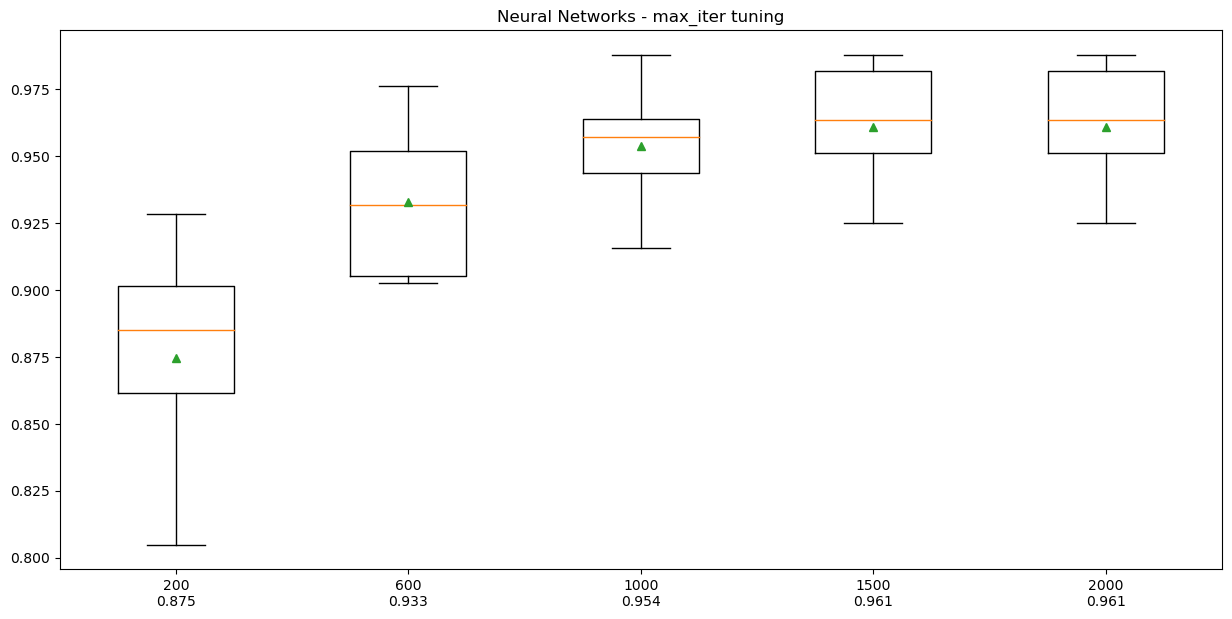

In [72]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', MLPClassifier(max_iter = value,random_state = g_random_state))])   
    return models

models = get_models([200, 600, 1000, 1500, 2000])
mx = myreturn_results(models, data, target, 'Neural Networks - max_iter tuning')

We get better results for a bigger number of maximum iterations, but it stabilizes after 1500.

-  **hidden_layer_sizes (default=(100,))**

The ith element represents the number of neurons in the ith hidden layer.

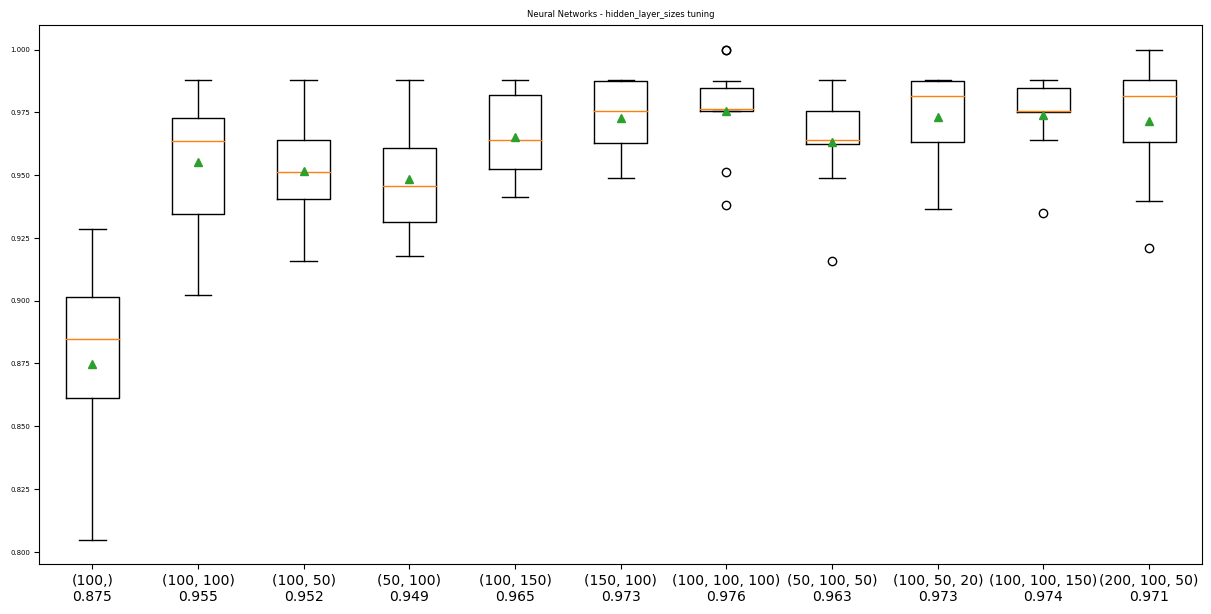

In [73]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', MLPClassifier(hidden_layer_sizes = value,random_state = g_random_state))])   
    return models

plt.rcParams.update({'font.size': 5})
models = get_models([(100,),(100,100),(100,50),(50,100),(100,150),(150,100),(100,100,100),(50,100,50),(100,50,20),(100,100,150),(200,100,50)])
mx = myreturn_results(models, data, target, 'Neural Networks - hidden_layer_sizes tuning')

The f1 score is better when we use 3 hidden layers, with 100 neurons in each layer.

- **activation (default='relu')**

Activation function for the hidden layer
 - ‘identity’, no-op activation, useful to implement linear bottleneck, returns f(x) = x 
 - ‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x))
 - ‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x)
 - ‘relu’, the rectified linear unit function, returns f(x) = max(0, x)

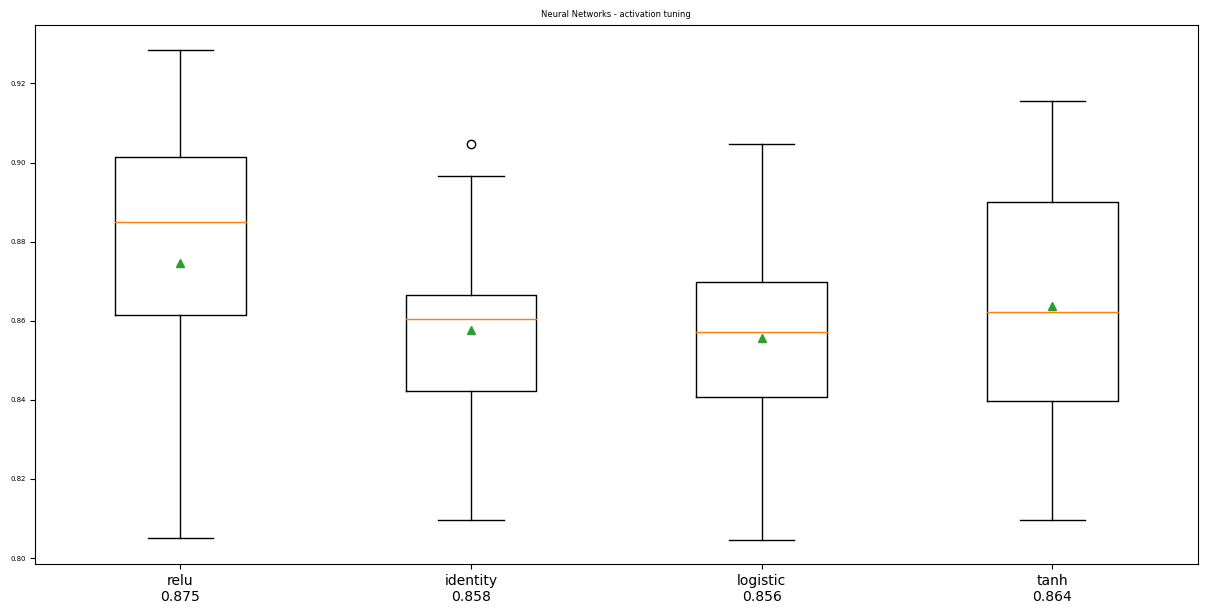

In [74]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', MLPClassifier( activation = value, random_state = g_random_state))])   
    return models

models = get_models(['relu', 'identity', 'logistic', 'tanh'])
mx = myreturn_results(models, data, target, 'Neural Networks - activation tuning')

Similar results, but we get a better f1 score for activation set to 'relu'.

- **solver (default='adam')**

The solver for weight optimization.
 - ‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
 - ‘sgd’ refers to stochastic gradient descent.
 - ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba \
__Note__: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) \
      in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and \
      perform better.

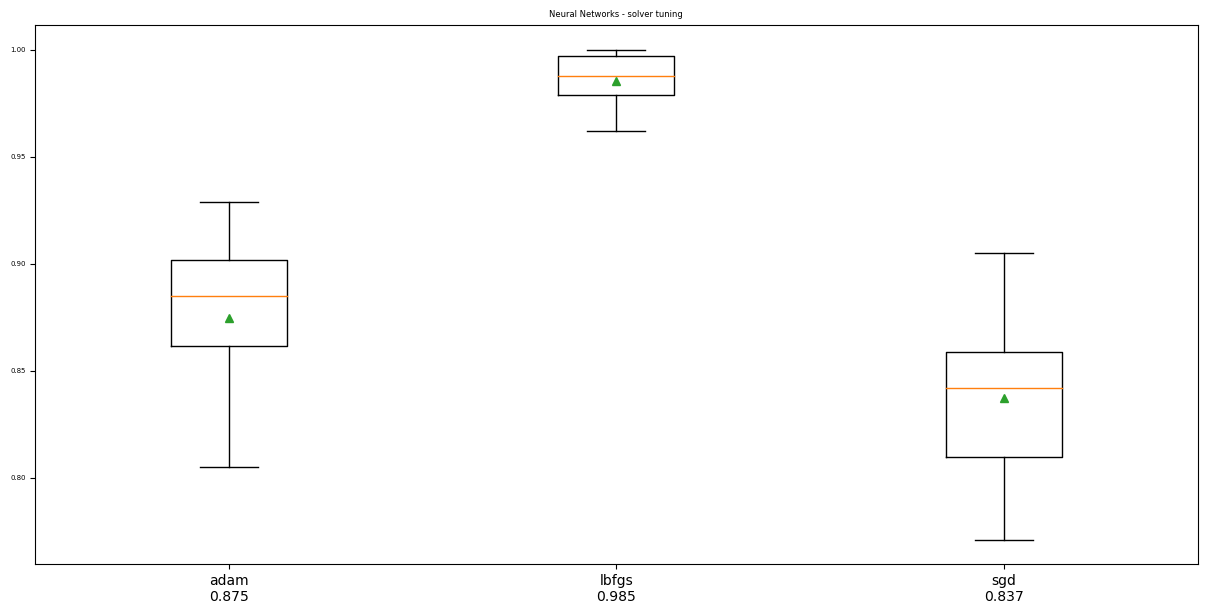

In [75]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', MLPClassifier(solver = value, random_state = g_random_state))])   
    return models

models = get_models(['adam', 'lbfgs', 'sgd'])
mx = myreturn_results(models, data, target, 'Neural Networks - solver tuning')

Significantly better results for solver='lbfgs'.

- **alpha (default=0.0001)**

Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss. \
alpha is a good parameter for reducing overfitting \
Alpha is a parameter for regularization term, aka penalty term, that combats overfitting by constraining the size of the weights.

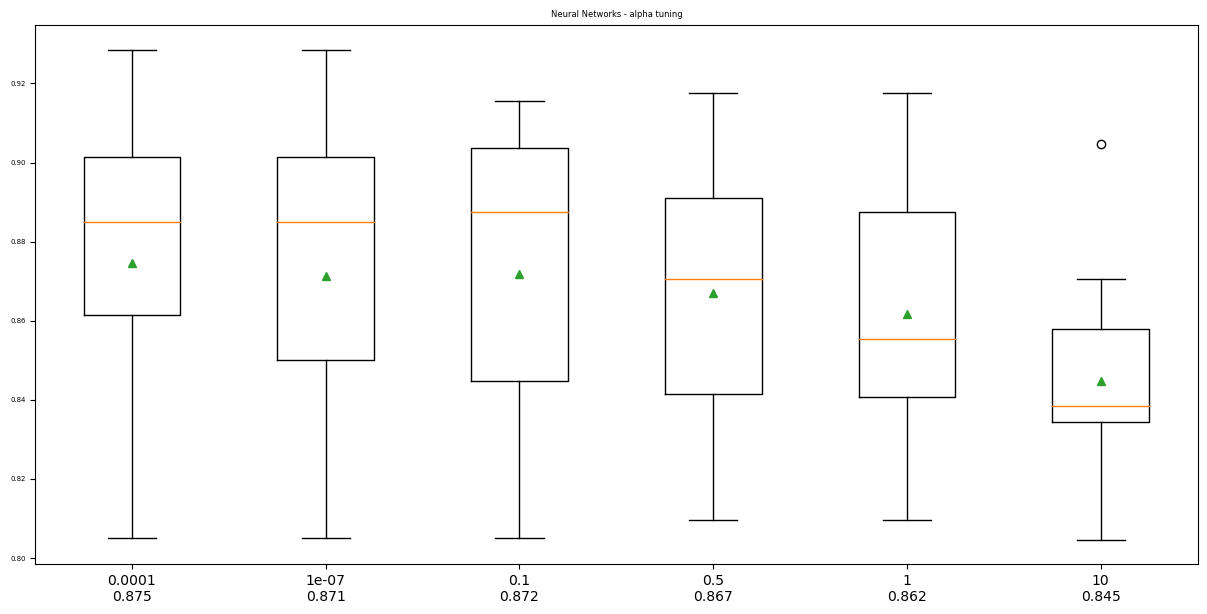

In [76]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', MLPClassifier(alpha=value,random_state = g_random_state))])   
    return models

models = get_models([0.0001, 0.0000001, 0.1, 0.5, 1, 10])
mx = myreturn_results(models, data, target, 'Neural Networks - alpha tuning')

Generally, the smaller the alpha the higher the f1 score. However, using the default setting leads to a slightly worse result and with a larger variance.

- **batch_size (default='auto', batch_size=min(200, n_samples))**

Batch size is the number of training examples utilized in one iteration

The batch size can affect significantly the performance and the speed of your training. What happens when you put a batch through your network is that you average the gradients. <br>

__In theory, for the generality of the cases:__ 

__Small batch size__
- The lower the batch size, the higher the probability of your estimate being less accurate, since the networks weights can "jump" around if your data is noisy, and it might be unable to learn, or it converges very slow. Besides that, the computation time is going to increase.
- It can be useful in some cases to escape local minima.
- Sometimes, and depending on your computational resources, this is the only option.

__Big batch size__
- If your batch size is big enough, this will provide a stable enough estimate of what the gradient of the full dataset would be, since you will have fewer gradient updates per epoch.
- In the same logic, it is desired to speed up computation, due to a lower quantity of updates.
- (1 demora mui tempo)

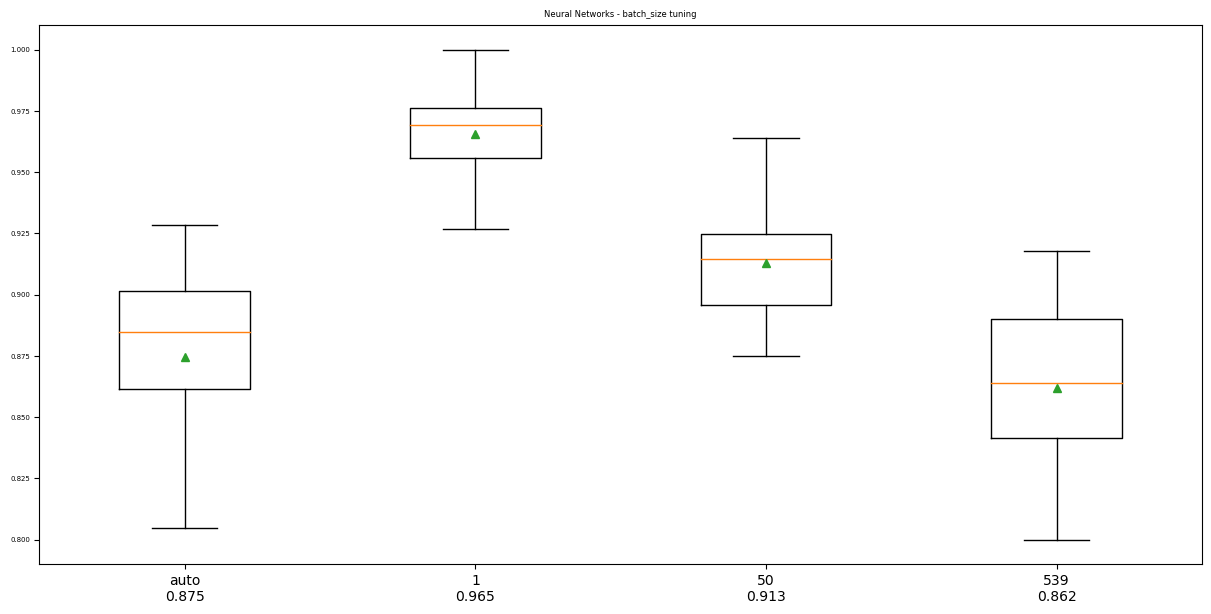

In [77]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', MLPClassifier(batch_size=value,random_state = g_random_state))])   
    return models

models = get_models(['auto',1,50, len(X_train)])
mx = myreturn_results(models, data, target, 'Neural Networks - batch_size tuning')

We get a significantly higher f1 score using batch_size = 1.

- **learning_rate (default='constant')**

Learning rate schedule for weight updates.

 - ‘constant’ is a constant learning rate given by ‘learning_rate_init’.

 - ‘invscaling’ gradually decreases the learning rate at each time step ‘t’ using an inverse scaling exponent of ‘power_t’.        effective_learning_rate = learning_rate_init / pow(t, power_t)

 - ‘adaptive’ keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing. Each time two    consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if      ‘early_stopping’ is on, the current learning rate is divided by 5.

Only used when solver='sgd'.

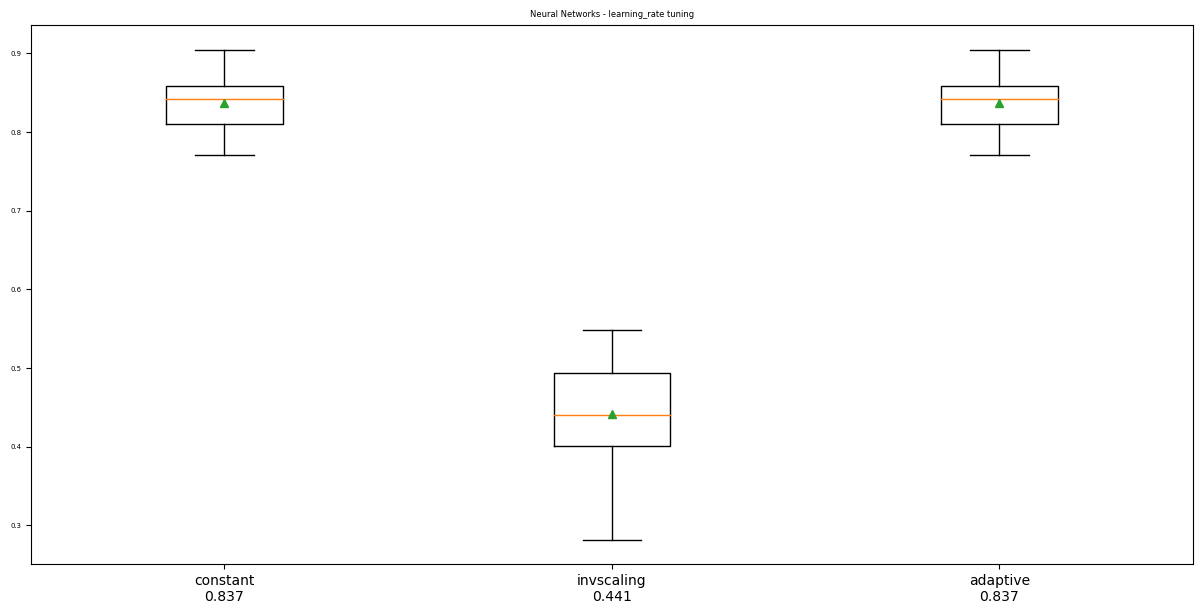

In [78]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', MLPClassifier(learning_rate=value,random_state = g_random_state, solver = 'sgd'))])   
    return models

models = get_models(['constant','invscaling','adaptive'])
mx = myreturn_results(models, data, target, 'Neural Networks - learning_rate tuning')

Better f1 score for learning_rate set to 'constant' or to 'adaptive'.

- **learning_rate_init (default=0.001)**

The initial learning rate used. It controls the step-size in updating the weights. Only used when solver=’sgd’ or ‘adam’.

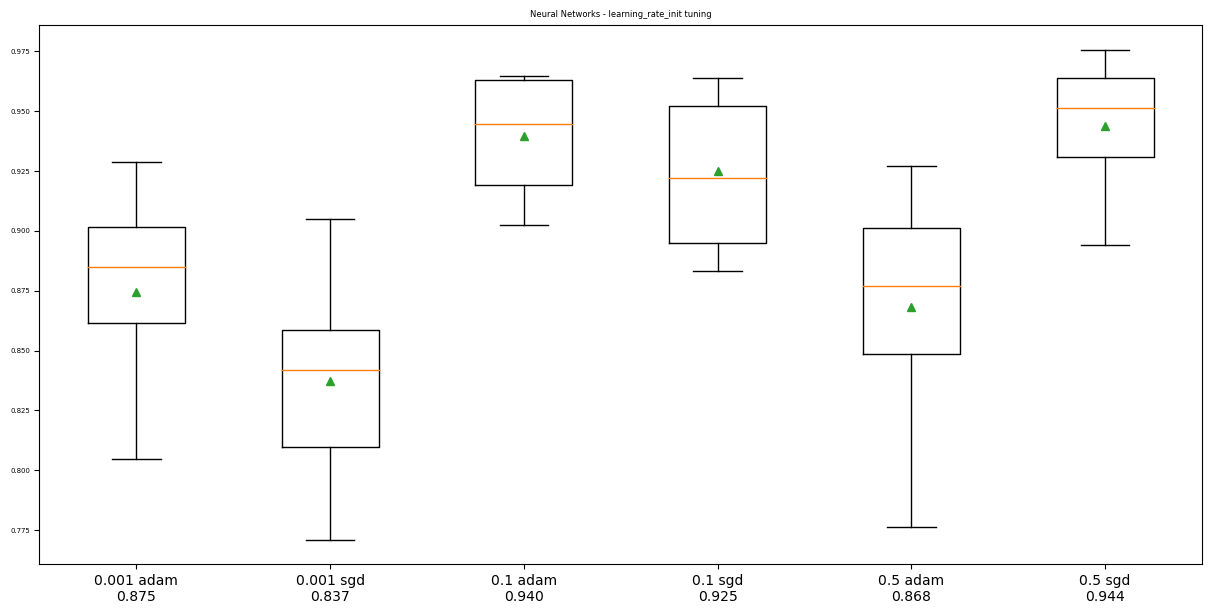

In [79]:
def get_models(values,solvers):
    models = dict()
    for value in values:
        for slv in solvers:
            models[str(value)+' '+ slv] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', MLPClassifier(learning_rate_init=value,random_state = g_random_state, solver = slv))])   
        
    return models

models = get_models([0.001, 0.1, 0.5], ['adam', 'sgd'])
mx = myreturn_results(models, data, target, 'Neural Networks - learning_rate_init tuning')

We get better f1 scores when we use learning_rate_init=0.1 with the solvers adam and sgd and when we use learning_rate_init=0.5 with the solver sgd.

#### early_stopping (default=False)

Whether to use early stopping to terminate training when validation score is not improving. \
If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. If early stopping is False, then the training stops when the training loss does not improve by more than tol for n_iter_no_change consecutive passes over the training set. Only effective when solver=’sgd’ or ‘adam’.

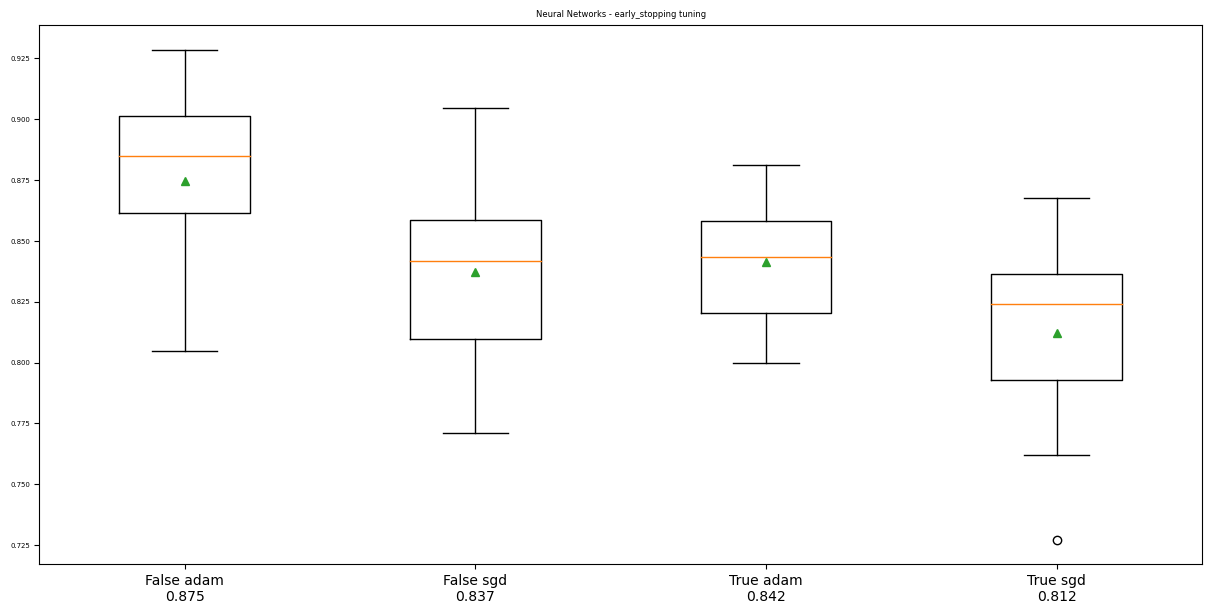

In [80]:
def get_models(values,solvers):
    models = dict()
    for value in values:
        for slv in solvers:
            models[str(value)+' '+ slv] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', MLPClassifier(early_stopping = value,random_state = g_random_state, solver=slv))])   
    return models

models = get_models([False, True],['adam', 'sgd'])
mx = myreturn_results(models, data, target, 'Neural Networks - early_stopping tuning')

The worst f1 score is achieved when early_stopping=True for solver='sgd'.

#### tol (default=1e-4)

Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to ‘adaptive’, convergence is considered to be reached and training stops.

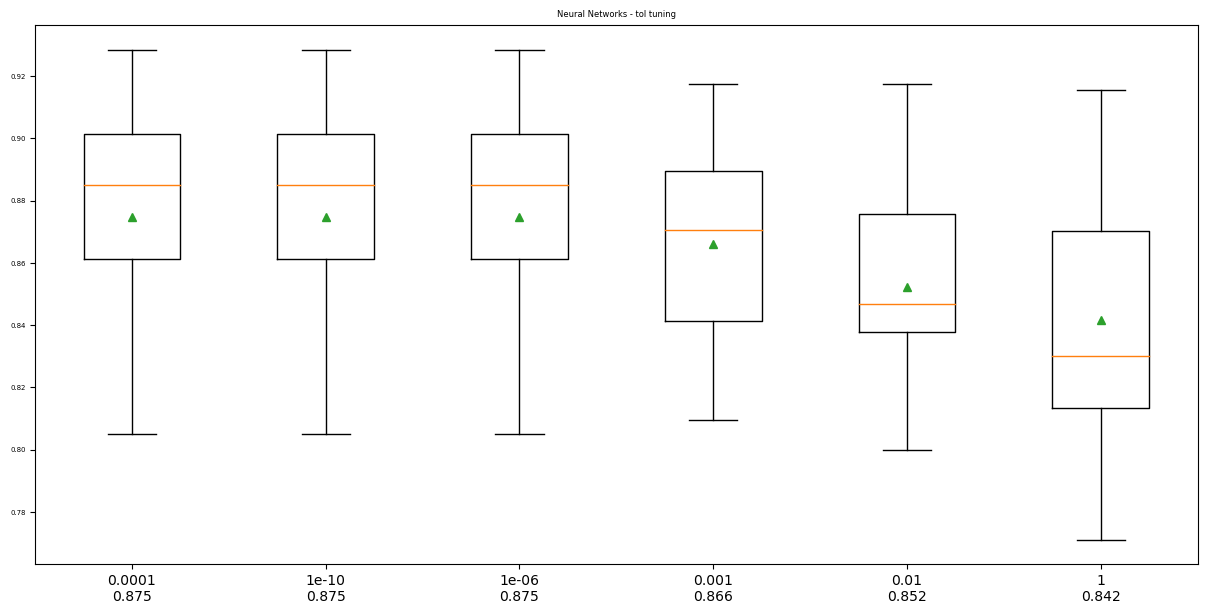

In [81]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = Pipeline(steps=[('col_trans', col_trans),
                                             ('model', MLPClassifier(tol = value,random_state = g_random_state))])   
    return models

models = get_models([0.0001, 0.0000000001, 0.000001, 0.001, 0.01, 1])
mx = myreturn_results(models, data, target, 'Neural Networks - tol tuning')

Although it doesn't change much, the best results come from smaller tols.

### 8.6 Use RandomizedSearchCV to get good ballpark values for hyperparameters

In [82]:
param_space_broad = {
    'model__solver' : ['lbfgs'],
    'model__max_iter': [1500],
    'model__hidden_layer_sizes': [(100, 100),(100, 50, 20),(100, 100, 150),(200, 100, 50)],
    'model__activation' : ['identity', 'tanh', 'relu'],
    'model__alpha' : [0.0000001, 0.0001,0.1],
    'model__batch_size': [1],
    'model__tol': [0.0001,0.001]
}


randsearchnn = RandomizedSearchCV(pipeline_nn, param_space_broad, n_iter=500, scoring='f1', n_jobs=-1, random_state=g_random_state)

In [83]:
randsearchnn.fit(X_train, y_train)

/Users/martadinis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/martadinis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/martadinis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs fa

/Users/martadinis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/martadinis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/martadinis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs fa

RandomizedSearchCV(estimator=Pipeline(steps=[('col_trans',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('pipe_ordinals',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('oe_ordinals',
                                                                                                OrdinalEncoder(categories=[['I '
                                                                                                                            'do '
                                                                                                                            'not '
                                                                                                                            'consume '
                                                                                                                            'any '
                                                                                                                            'type '
                                                                                                                            'of '
                                                                                                                            'alcohol',
                                                                                                                            'I '
                                                                                                                            'consider '
                                                                                                                            'myself '
                                                                                                                            'a '
                                                                                                                            'social '
                                                                                                                            'drinker',
                                                                                                                            'I '
                                                                                                                            'usually '
                                                                                                                            'consume '
                                                                                                                            'alcohol '
                                                                                                                            'ever...
                                                            random_state=53))]),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'model__activation': ['identity',
                                                              'tanh', 'relu'],
                                        'model__alpha': [1e-07, 0.0001, 0.1],
                                        'model__batch_size': [1],
                                        'model__hidden_layer_sizes': [(100,
                                                                       100),
                                                                      (100, 50,
                                                                       20),
                                                                      (100, 100,
                                                                       150),
           

### 8.7 GridSearchCV using the approximate values found in the previous step, fine-tune the Hyperparameters

In [84]:
# range__alpha
if randsearchnn.best_params_['model__alpha']==0.0000001:
    range__alpha = np.round_(np.arange(-1.5*randsearchnn.best_params_['model__alpha'],1.5*randsearchnn.best_params_['model__alpha'],0.00000005),2)
elif randsearchnn.best_params_['model__alpha']==0.0001:
    range__alpha = np.round_(np.arange(-1.5*randsearchnn.best_params_['model__alpha'],1.5*randsearchnn.best_params_['model__alpha'],0.00005),2)
else:
    range__alpha = np.round_(np.arange(-1.5*randsearchnn.best_params_['model__alpha'],1.5*randsearchnn.best_params_['model__alpha'],0.05),2)

    
# range__tol
if randsearchnn.best_params_['model__tol']==0.0001:
    range__tol = np.round_(np.arange(-1.5*randsearchnn.best_params_['model__tol'],1.5*randsearchnn.best_params_['model__tol'],0.00005),2)
else:
    range__tol = np.round_(np.arange(-1.5*randsearchnn.best_params_['model__tol'],1.5*randsearchnn.best_params_['model__tol'],0.0005),2)

param_space_fine_tune = {
    'model__solver': [randsearchnn.best_params_['model__solver']],
    'model__max_iter': [randsearchnn.best_params_['model__max_iter']],
    'model__hidden_layer_sizes': [randsearchnn.best_params_['model__hidden_layer_sizes']],
    'model__activation': [randsearchnn.best_params_['model__activation']],
    'model__alpha': range__alpha,
    'model__batch_size': [randsearchnn.best_params_['model__batch_size']],
    'model__tol': range__tol
}

gridsearchnn = GridSearchCV(pipeline_nn, param_space_fine_tune, scoring = 'f1', return_train_score = True)

In [85]:
gridsearchnn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('pipe_ordinals',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('oe_ordinals',
                                                                                          OrdinalEncoder(categories=[['I '
                                                                                                                      'do '
                                                                                                                      'not '
                                                                                                                      'consume '
                                                                                                                      'any '
                                                                                                                      'type '
                                                                                                                      'of '
                                                                                                                      'alcohol',
                                                                                                                      'I '
                                                                                                                      'consider '
                                                                                                                      'myself '
                                                                                                                      'a '
                                                                                                                      'social '
                                                                                                                      'drinker',
                                                                                                                      'I '
                                                                                                                      'usually '
                                                                                                                      'consume '
                                                                                                                      'alcohol '
                                                                                                                      'every '
                                                                                                                      'day...
                                                                          'Gender'])])),
                                       ('model',
                                        MLPClassifier(max_iter=1000,
                                                      random_state=53))]),
             param_grid={'model__activation': ['relu'],
                         'model__alpha': array([-0., -0., -0., -0.,  0.,  0.]),
                         'model__batch_size': [1],
                         'model__hidden_layer_sizes': [(100, 100)],
                         'model__max_iter': [1500], 'model__solver': ['lbfgs'],
                         'model__tol': array([-0., -0., -0., -0.,  0.,  0.])},
             return_train_score=True, scoring='f1')

### 8.8 Best Parameters for our model

In [86]:
print("Best parameters using RandomizedSearchCV\n{}".format( randsearchnn.best_params_))
print("Best parameters using GridSearchCV\n{}".format( gridsearchnn.best_params_))

Best parameters using RandomizedSearchCV
{'model__tol': 0.0001, 'model__solver': 'lbfgs', 'model__max_iter': 1500, 'model__hidden_layer_sizes': (100, 100), 'model__batch_size': 1, 'model__alpha': 0.0001, 'model__activation': 'relu'}
Best parameters using GridSearchCV
{'model__activation': 'relu', 'model__alpha': -0.0, 'model__batch_size': 1, 'model__hidden_layer_sizes': (100, 100), 'model__max_iter': 1500, 'model__solver': 'lbfgs', 'model__tol': -0.0}


In [87]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', gridsearchnn.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = gridsearchnn.cv_results_['mean_test_score']
stds = gridsearchnn.cv_results_['std_test_score']
mean_trains = gridsearchnn.cv_results_['mean_train_score']
params = gridsearchnn.cv_results_['params']

results = pd.DataFrame(zip(means, stds, mean_trains, params), columns=['Mean Val','Std','Mean Train','Params'])
results.sort_values(by=['Mean Val'], inplace = True, ascending = False)
results

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'model__activation': 'relu', 'model__alpha': -0.0, 'model__batch_size': 1, 'model__hidden_layer_sizes': (100, 100), 'model__max_iter': 1500, 'model__solver': 'lbfgs', 'model__tol': -0.0}
------------------------------------------------------------------------------------------------------------------------


,Mean Val,Std,Mean Train,Params
0,0.941778,0.023248,0.99695,"{'model__activation': 'relu', 'model__alpha': ..."
1,0.941778,0.023248,0.99695,"{'model__activation': 'relu', 'model__alpha': ..."
20,0.941778,0.023248,0.99695,"{'model__activation': 'relu', 'model__alpha': ..."
21,0.941778,0.023248,0.99695,"{'model__activation': 'relu', 'model__alpha': ..."
22,0.941778,0.023248,0.99695,"{'model__activation': 'relu', 'model__alpha': ..."
23,0.941778,0.023248,0.99695,"{'model__activation': 'relu', 'model__alpha': ..."
24,0.941778,0.023248,0.99695,"{'model__activation': 'relu', 'model__alpha': ..."
25,0.941778,0.023248,0.99695,"{'model__activation': 'relu', 'model__alpha': ..."
26,0.941778,0.023248,0.99695,"{'model__activation': 'relu', 'model__alpha': ..."
27,0.941778,0.023248,0.99695,"{'model__activation': 'relu', 'model__alpha': ..."


In [88]:
model = MLPClassifier(solver = gridsearchnn.best_params_['model__solver'],
                               max_iter = gridsearchnn.best_params_['model__max_iter'],
                               hidden_layer_sizes = gridsearchnn.best_params_['model__hidden_layer_sizes'],
                               activation = gridsearchnn.best_params_['model__activation'],
                               alpha = gridsearchnn.best_params_['model__alpha'],
                               batch_size = gridsearchnn.best_params_['model__batch_size'],
                               tol = gridsearchnn.best_params_['model__tol'])

best_NN = Pipeline(steps=[
    ('col_trans', col_trans),
    ('best_NN_model', model)])
    
best_models_ls.append(('best_NN',best_NN))

<a class="anchor" id="topic09"> <br>
    
## Step 9 - Ensembles

Ensembles are models that use other models to harvest knowledge from the data, and then combine the results of these distinct models to obtain a better prediction.

For this purpose we may:
- Ant farm:
use a large number of slow-learning models, with high variance, and combine them to make accurate predictions;
- Elephants:
use a small number of strong models that are a lot more accurate in predicting results, then combine them to improve each model's prediction.

Work on the prediction from the first model, puting enphasis on missed predictions

## 9.1. Bagging classifier (bootstrapping and aggregating)


The Bagging classifier uses independent models, gets a prediction from each of them and then combines the prediction to get a final prediction.

Each model is fitted using just a subset of the available data:
- Feature reduction (a.k.a. Random Subspaces: only a percentage of available features is used);
- Observation reduction (a.k.a. Pasting: only a percentage of the observations is used);
- If the selection is done with repetition, this is called bootstraping;
- Symultaneous Feature and Observation reduction (a.k.a. random patches);


As a starting point we need to decide the number of sub-models to create, the % of samples
and the % of features that will be presented to each sub-model.
We opted to use the values obtained in the GridSearch for RandomForests, as they match in structure and
somehow in configuration the ensembles that we're creating.

In [89]:
# Initial values after some experimentation
n_estim = 100
max_samp = 0.5
max_feat = 0.9

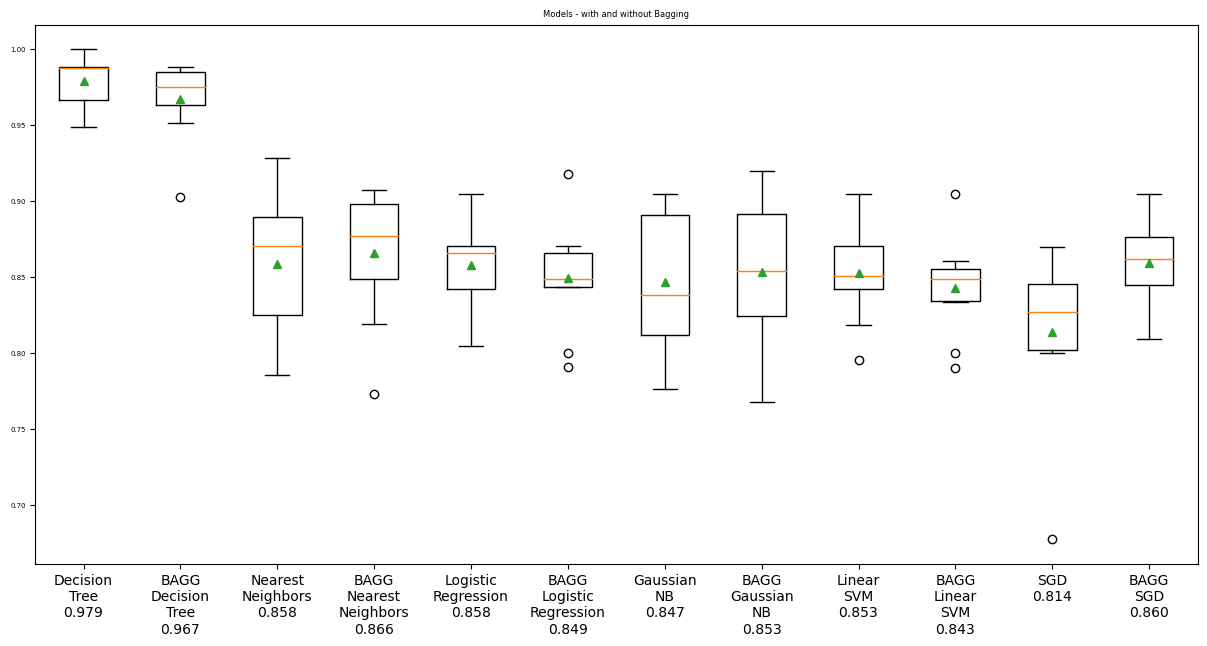

In [90]:
def get_bagging_models():
    
    # We will not be using only DecisionTreeRegressors for bagging, but it seems to make sense to get the
    # best parameters from the Random Forest optimization for this high-level approach

    models = dict()
    retmodels = dict()
    models["Decision\nTree"] = DecisionTreeClassifier(random_state = g_random_state)
    models["Nearest\nNeighbors"] = KNeighborsClassifier()
    models["Logistic\nRegression"] = LogisticRegression(random_state = g_random_state)
    models["Gaussian\nNB"] = GaussianNB()
    models["Linear\nSVM"] = SVC(kernel="linear",C=0.025,random_state = g_random_state)
    models["SGD"] = SGDClassifier(random_state = g_random_state)
    
    for name,model in models.items():
        vprint(name, model)
        retmodels[name] = Pipeline(steps=[('col_trans', col_trans), ('model', model)])
        retmodels["BAGG\n" + name] = Pipeline(steps=[('col_trans', col_trans), ('model',
                BaggingClassifier(base_estimator = model, n_estimators = n_estim, max_samples = max_samp, max_features = max_feat))]) 

    return retmodels

models = get_bagging_models()
mx = myreturn_results( models, data, target, 'Models - with and without Bagging')

#### Conclusions:
There are significant discrepancies between the results obtained using bagging for each base model.
With some exceptions, it seems that the models that have the worst performance when applied directly are those that get the best results when applied in bagging and, ad contrarium, the model with best individual performance - DecisionTreeRegressor - is the one that gets more penalized when bagged.<br>Nonetheless, the decision trees are, together with K nearest neighbors, the models that provide the best result after bagging.

In [91]:
# We will not be using only K Nearest Neighbors regressor for bagging, but it seems to make sense to get the
# best parameters from the Random Forest optimization for this high-level approach

l_n_estim = [int(n_estim /2), n_estim ]
l_max_samples = [ max( max_samp*.5, 0.1), max_samp , min(max_samp*1.5, 0.9)]
l_max_features = [ max( max_feat*.5, 0.1), max_feat , min(max_feat*1.5, 0.9)]

In [92]:
def get_bagging_models_dt(bootstrap_value):
    # We will not be using only DecisionTreeRegressors for bagging, but it seems to make sense to get the
    # best parameters from the Random Forest optimization for this high-level approach

    models = dict()
    models["D.Tree"] = DecisionTreeClassifier(random_state = g_random_state)
    
    retmodels = dict()
    for name,model in models.items():
        retmodels[name+"\n(base)"] = Pipeline(steps=[('col_trans', col_trans), ('model', model)])
        for n in l_n_estim:
            for s in l_max_samples:
                for f in l_max_features:
                    retmodels[name+"\nn:"+str(int(n))+"\ns:"+str(round(s,2))+"\nf:"+str(round(f,2))] = \
                        Pipeline(steps=[('col_trans', col_trans), ('model',\
                        BaggingClassifier(bootstrap=bootstrap_value, base_estimator = model, n_estimators = n, max_samples = s, max_features = f))]) 
                    
    return retmodels


def get_bagging_models_knn(bootstrap_value):
   
    models = dict()
    models["KNN"] = KNeighborsClassifier()
     
    retmodels = dict()
    for name,model in models.items():
        retmodels[name+"\n(base)"] = Pipeline(steps=[('col_trans', col_trans), ('model', model)])
        for n in l_n_estim:
            for s in l_max_samples:
                for f in l_max_features:
                    retmodels[name+"\nn:"+str(int(n))+"\ns:"+str(round(s,2))+"\nf:"+str(round(f,2))] = \
                        Pipeline(steps=[('col_trans', col_trans), ('model',\
                        BaggingClassifier(bootstrap = bootstrap_value, base_estimator = model, n_estimators = n, max_samples = s, max_features = f))]) 
                    
    return retmodels

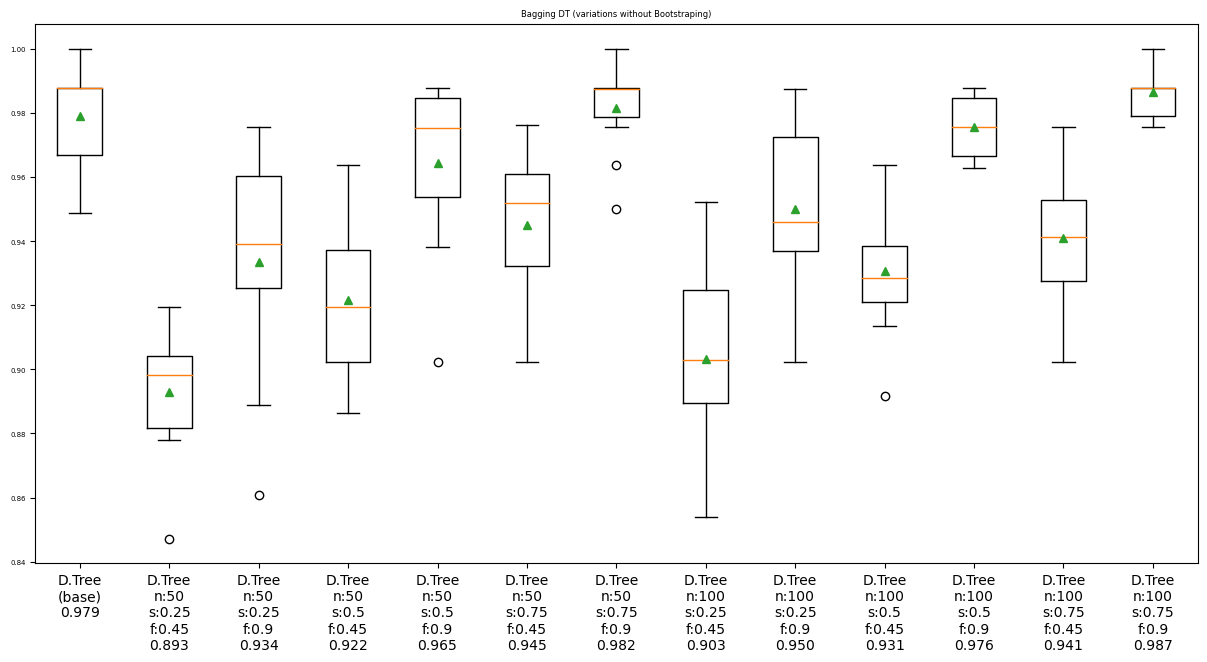

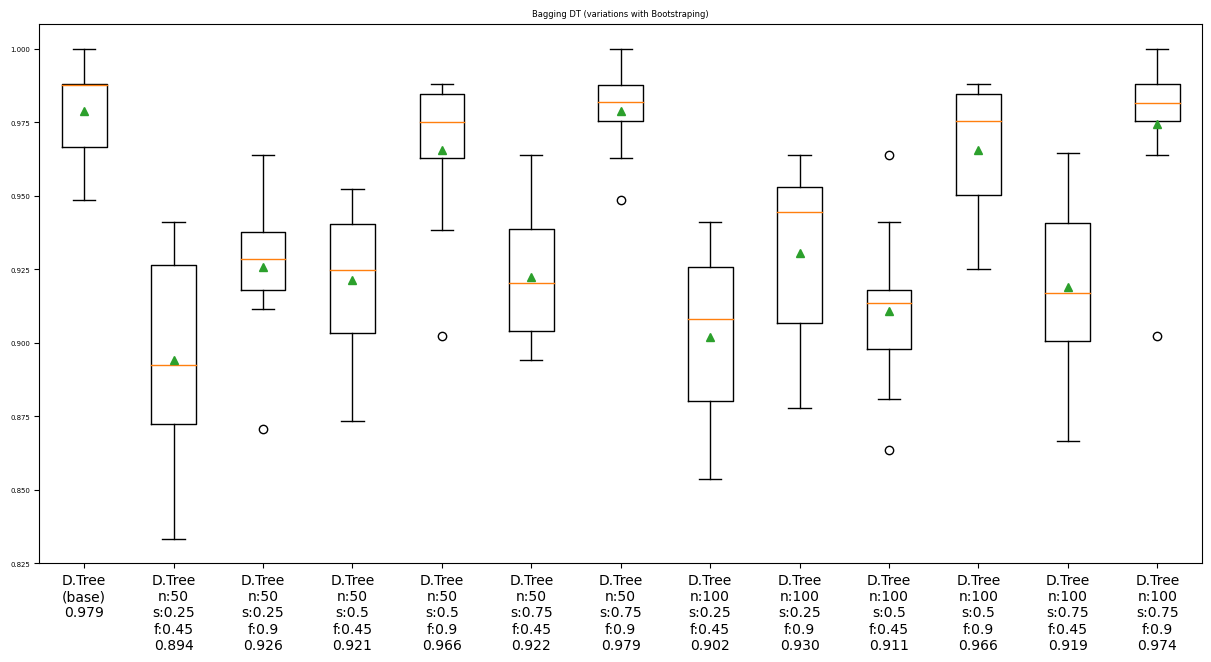

In [93]:
models = get_bagging_models_dt(bootstrap_value=False)
mx = myreturn_results( models, data, target, 'Bagging DT (variations without Bootstraping)')

models = get_bagging_models_dt(bootstrap_value=True)
mx = myreturn_results( models, data, target, 'Bagging DT (variations with Bootstraping)')

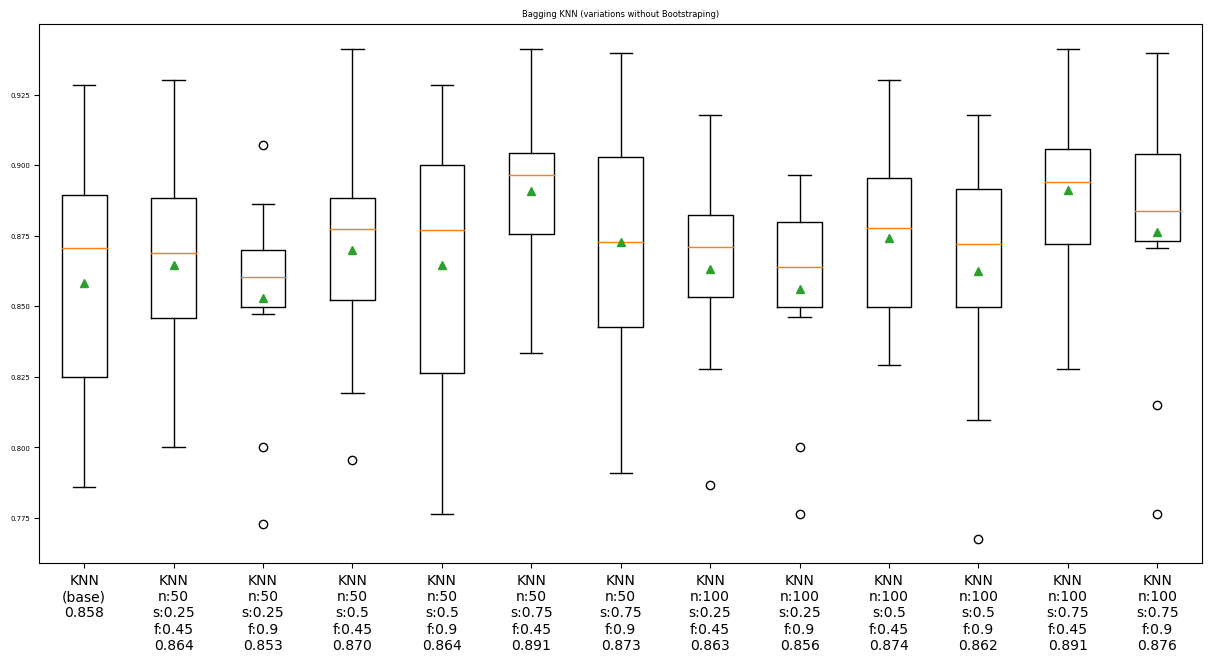

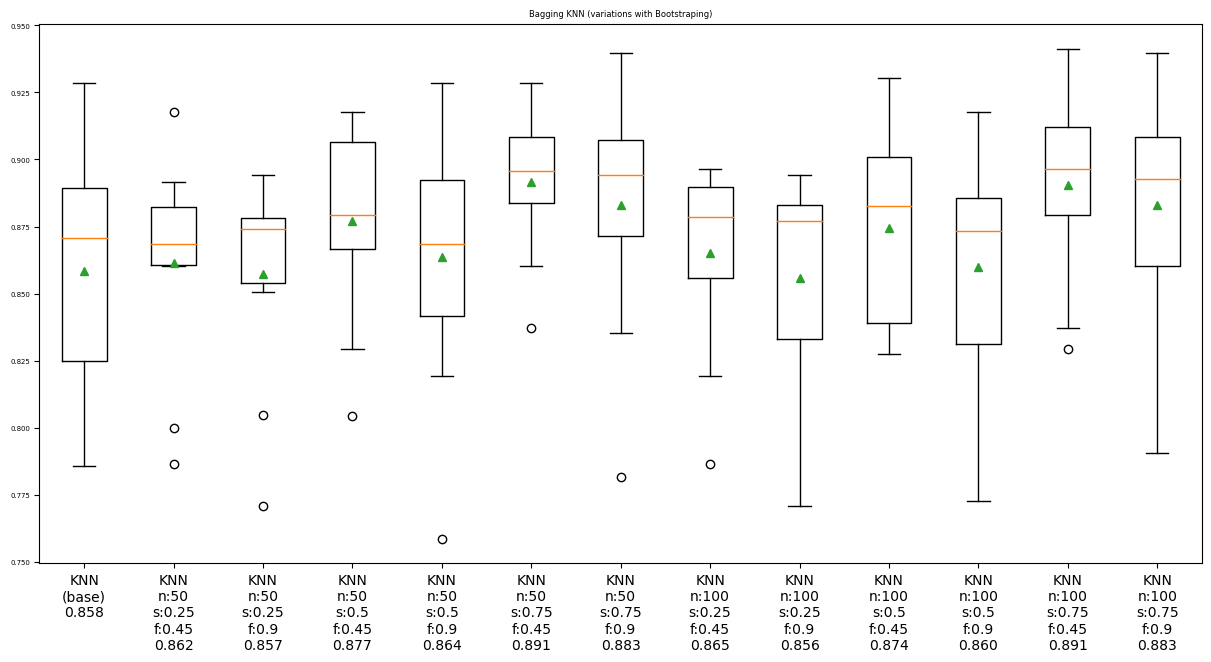

In [94]:
models = get_bagging_models_knn(bootstrap_value=False)
mx = myreturn_results( models, data, target, 'Bagging KNN (variations without Bootstraping)')

models = get_bagging_models_knn(bootstrap_value=True)
mx = myreturn_results( models, data, target, 'Bagging KNN (variations with Bootstraping)')

Conclusions: Bagging is not useful for our context:
- with Decision trees, we're worse off with bagging than using a single decision tree;
- with K Nearest Neighbors, we observe a significant improvement, but it's still far from the results from other models.


In [95]:
model = BaggingClassifier(bootstrap = False, base_estimator = DecisionTreeClassifier(), n_estimators = 100, max_samples = 0.75, max_features = 0.9)

best_BO = Pipeline(steps=[
    ('col_trans', col_trans),
    ('best_BO_model', model)])
    
best_models_ls.append(('best_BO',best_BO))             

## 9.2 Boosting

#### 9.2.1 Ada Boosting
Contrary to RF, in Ada boost:
    - We do not grow full trees, just stumps or trees with reduced levels;
    - Not all trees have the same weight in the final decision;
    - Each estimator will use the information from the previous estimador, specifically the classification mistakes
    

In [96]:
def get_adaboost_models():
    
    l_depth = range(1,11)
    
    models = dict()
    models["Adaboost"] = AdaBoostClassifier()
     
    retmodels = dict()
    retmodels["Decision\nTree"] = Pipeline(steps=[('col_trans', col_trans), ('model',\
                 DecisionTreeClassifier(random_state = g_random_state))])
    retmodels["Random\Forest"] = Pipeline(steps=[('col_trans', col_trans), ('model',\
                 RandomForestClassifier(random_state = g_random_state))])

    for ndep in l_depth:
        retmodels["Adaboost\ndepth:"+str(int(ndep))] = \
            Pipeline(steps=[('col_trans', col_trans), ('model',\
            AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=ndep), random_state = g_random_state))]) 


    return retmodels

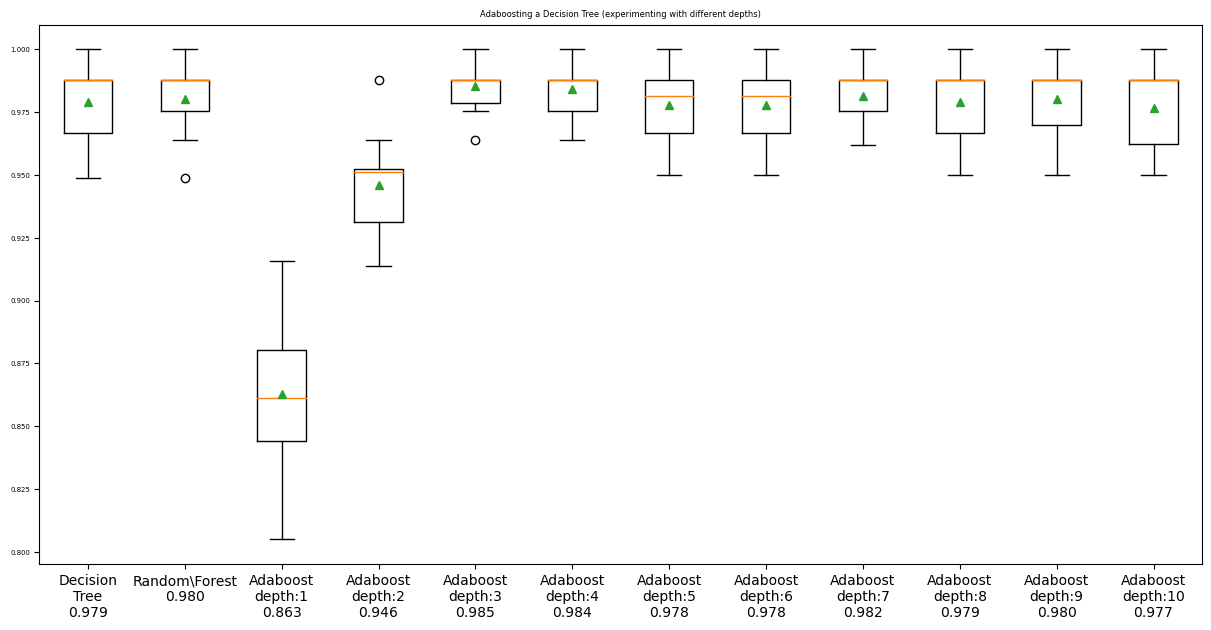

In [97]:
models = get_adaboost_models()
mx = myreturn_results( models, data, target, 'Adaboosting a Decision Tree (experimenting with different depths)')

Adaboosting is not fully dependent on Decision Trees. We can use some other models - preferably, weak learners.

In [98]:
model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=3), random_state = g_random_state)

best_AB = Pipeline(steps=[
    ('col_trans', col_trans),
    ('best_AB_model', model)])
    
best_models_ls.append(('best_AB',best_AB))           

#### 9.2.2 Gradient Boosting

In [99]:
def get_gradboost_models():
    
    l_depth = range(1,11)
    
    retmodels = dict()
    retmodels["Decision\nTree"] = Pipeline(steps=[('col_trans', col_trans), ('model',\
                 DecisionTreeClassifier(random_state = g_random_state))])
    retmodels["Random\Forest"] = Pipeline(steps=[('col_trans', col_trans), ('model',\
                 RandomForestClassifier(random_state = g_random_state))])
    

    for ndep in l_depth:
        retmodels["GradBoost\ndepth:"+str(int(ndep))] = \
            Pipeline(steps=[('col_trans', col_trans), ('model',\
            GradientBoostingClassifier(max_depth=ndep, random_state = g_random_state))]) 


    return retmodels

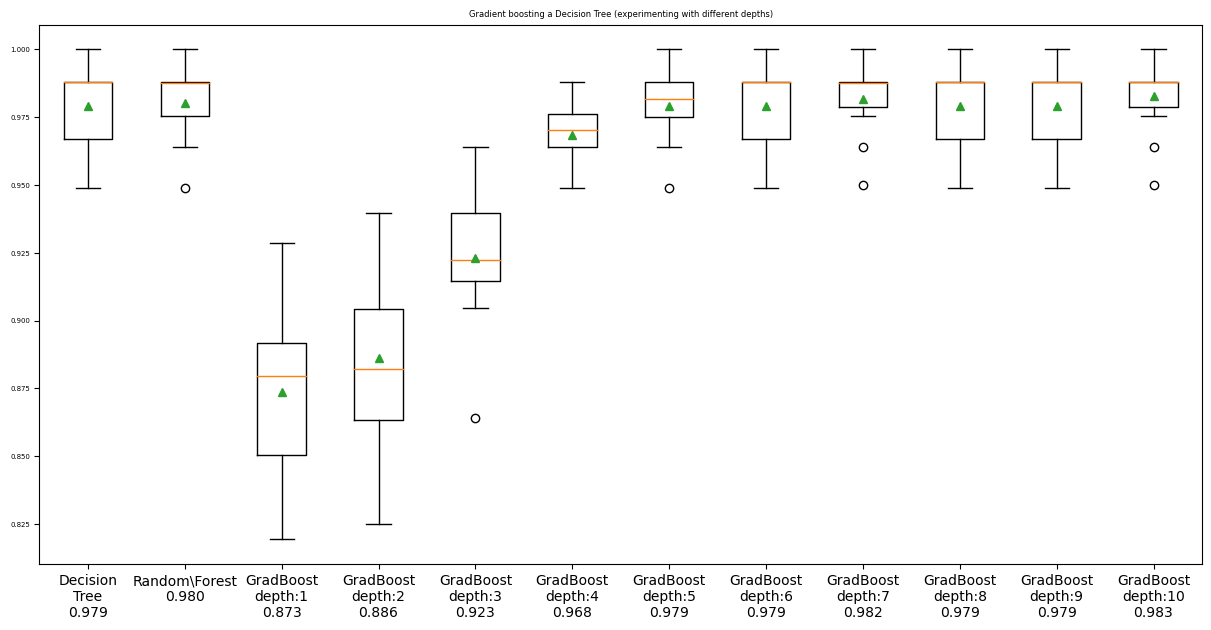

In [100]:
models = get_gradboost_models()
mx = myreturn_results( models, data, target, 'Gradient boosting a Decision Tree (experimenting with different depths)')

Best performance is achieved when depth is 10.

In [101]:
def get_gradboost_models_opts():
    
    l_depth = [5,6,7]
    l_learningrate = [0.05, 0.1, 0.3, 0.5, 1]
    
    models = dict()
    models["Gradientboost"] = GradientBoostingClassifier()
    
    retmodels = dict()
    retmodels["Decision\nTree"] = Pipeline(steps=[('col_trans', col_trans), ('model',\
                 DecisionTreeClassifier(random_state = g_random_state))])
    retmodels["Random\Forest"] = Pipeline(steps=[('col_trans', col_trans), ('model',\
                 RandomForestClassifier(random_state = g_random_state))])
 
    for ndep in l_depth:
        for lrate in l_learningrate:
            retmodels["GradB\ndepth:"+str(int(ndep))+"\nlearn:"+str(lrate)] = \
            Pipeline(steps=[('col_trans', col_trans), ('model',\
            GradientBoostingClassifier(learning_rate=lrate, max_depth=ndep, random_state = g_random_state))]) 


    return retmodels

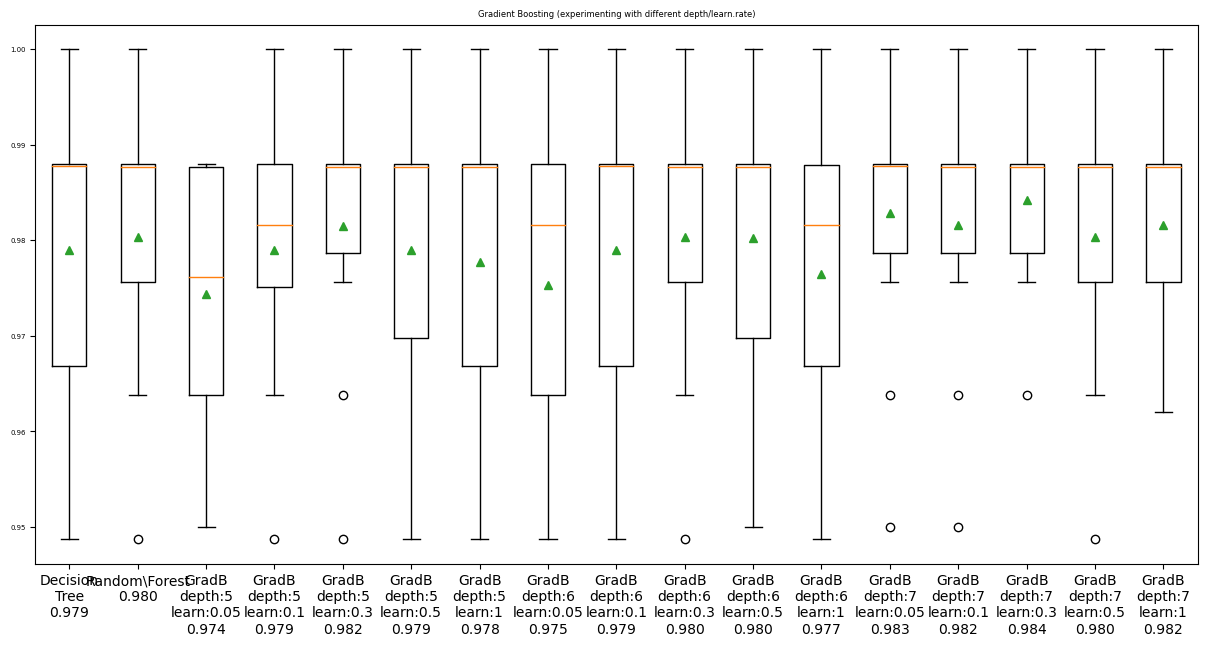

In [102]:
models = get_gradboost_models_opts()
mx = myreturn_results( models, data, target, 'Gradient Boosting (experimenting with different depth/learn.rate)')

Best performance is achieved when depth is 7 and learning rate is 0.3.

In [103]:
model = GradientBoostingClassifier(learning_rate=0.3, max_depth=7, random_state = g_random_state)

best_GB = Pipeline(steps=[
    ('col_trans', col_trans),
    ('best_GB_model', model)])
    
best_models_ls.append(('best_GB',best_GB))  

#### 9.3 Stacking

In [104]:
best_classifs = best_models_ls[0:2]

In [106]:
final_estim = LogisticRegression()

clf = StackingClassifier(estimators=best_classifs,final_estimator=final_estim)

best_ST = Pipeline(steps=[
    ('best_ST_model', clf)])

In [107]:
best_ST

Pipeline(steps=[('best_ST_model',
                 StackingClassifier(estimators=[('best_RF',
                                                 Pipeline(steps=[('col_trans',
                                                                  ColumnTransformer(n_jobs=-1,
                                                                                    transformers=[('pipe_ordinals',
                                                                                                   Pipeline(steps=[('impute',
                                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                                   ('oe_ordinals',
                                                                                                                    OrdinalEncoder(categories=[['I '
                                                                                                                                                'do '
                                                                                                                                                'not '
                                                                                                                                                'consume '
                                                                                                                                                'any '
                                                                                                                                                'type '
                                                                                                                                                'of '
                                                                                                                                                'alcohol',
                                                                                                                                                'I '
                                                                                                                                                'consider '
                                                                                                                                                'myself '
                                                                                                                                                'a '
                                                                                                                                                'social...
                                                                                                                   ('impute',
                                                                                                                    KNNImputer())]),
                                                                                                   ['Mental_Health',
                                                                                                    'Physical_Health']),
                                                                                                  ('pipe_bin',
                                                                                                   Pipeline(steps=[('impute',
                                                                                                                    SimpleImputer(strategy='most_frequent'))]),
                                                                                                   ['Smoking_Habit',
                                                                                                    'Exercise',
                                                                                                    'G

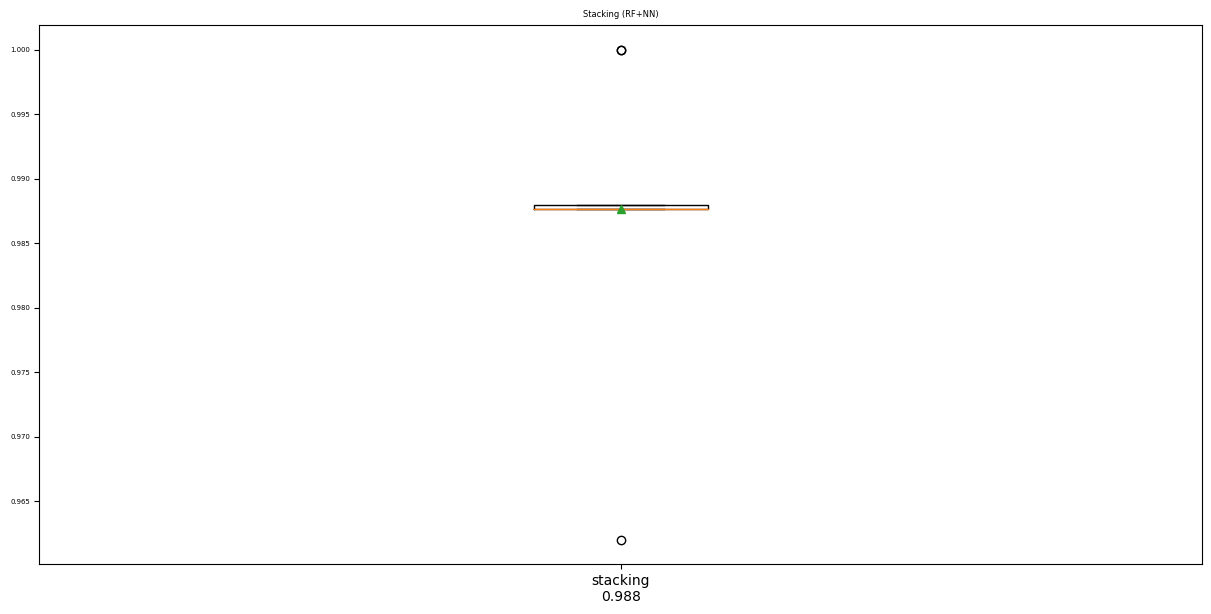

In [108]:
mx = myreturn_results( {"stacking":best_ST}, data, target, 'Stacking (RF+NN)')

In [109]:
best_models_ls.append(('best_ST',best_ST))

<a class="anchor" id="topic10"> <br>
# 10 - Comparing our models

In [110]:
for modelset in best_models_ls:
    model_name = modelset[0]
    model = modelset[1]
    time_start = datetime.datetime.now()
    print("-- Model: ", model_name)

    avg_score(cv, data, target, model)
    
    time_end = datetime.datetime.now()
    
    print("Elapsed seconds: ", (time_end - time_start).seconds)
    print("-------------------------------------\n")


-- Model:  best_RF
Train average score:0.996+/-0.001
Val average score:0.977+/-0.015
Overfitting abs(Train-Val):0.02
Elapsed seconds:  5
-------------------------------------

-- Model:  best_NN
Train average score:0.996+/-0.001
Val average score:0.983+/-0.015
Overfitting abs(Train-Val):0.014
Elapsed seconds:  42
-------------------------------------

-- Model:  best_BO
Train average score:0.997+/-0.001
Val average score:0.983+/-0.015
Overfitting abs(Train-Val):0.014
Elapsed seconds:  6
-------------------------------------

-- Model:  best_AB
Train average score:0.997+/-0.001
Val average score:0.985+/-0.011
Overfitting abs(Train-Val):0.011
Elapsed seconds:  2
-------------------------------------

-- Model:  best_GB
Train average score:0.997+/-0.001
Val average score:0.984+/-0.009
Overfitting abs(Train-Val):0.013
Elapsed seconds:  5
-------------------------------------

-- Model:  best_ST
Train average score:0.996+/-0.001
Val average score:0.99+/-0.007
Overfitting abs(Train-Val):0.00

In [111]:
best_models_dict={}
for name,model in best_models_ls:
    best_models_dict[name]=model

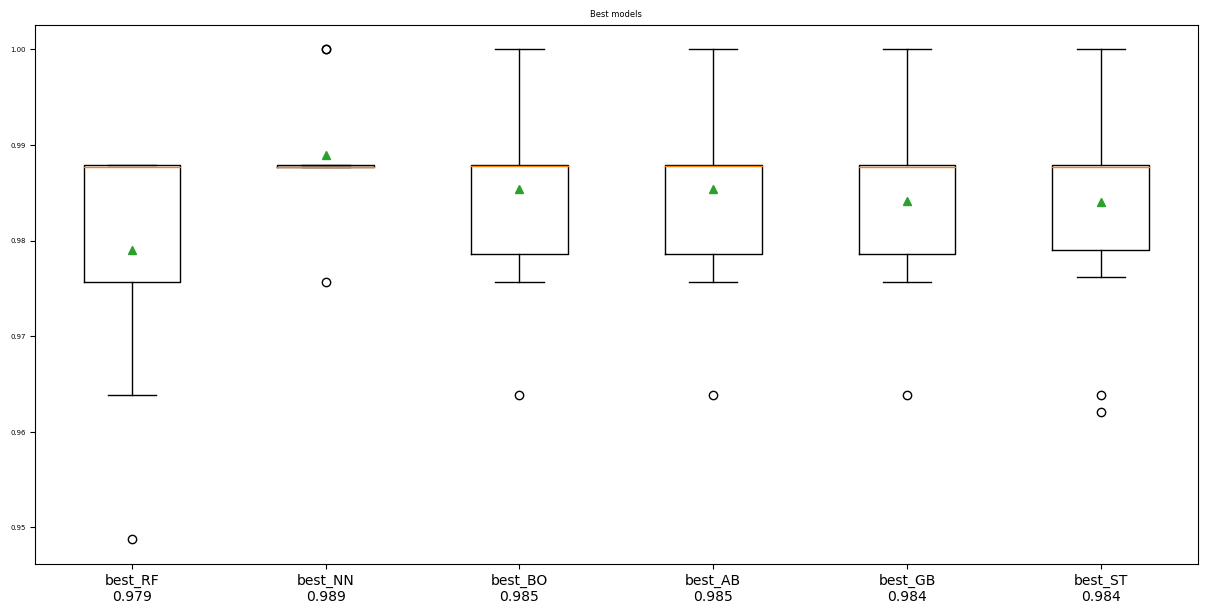

In [112]:
mx = myreturn_results(best_models_dict, data, target, 'Best models')

<a class="anchor" id="topic11"> <br>
# 11 - Final Model

In [113]:
avg_score(cv, data, target, best_NN)

Train average score:0.996+/-0.002
Val average score:0.982+/-0.013
Overfitting abs(Train-Val):0.014


<a class="anchor" id="topic12"> <br>
# 12 - Predictions for the Test Data

Get predictions for the Test Data with all train data

In [114]:
target = train_data['Disease']
X_train_data = train_data.drop(['Disease'],axis=1)

In [120]:
model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=3), random_state = g_random_state)

final_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', model)
])

# Display Pipeline
set_config(display='diagram')

#fit data
final_pipeline.fit(X_train_data, target)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('pipe_ordinals',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oe_ordinals',
                                                                   OrdinalEncoder(categories=[['I '
                                                                                               'do '
                                                                                               'not '
                                                                                               'consume '
                                                                                               'any '
                                                                                               'type '
                                                                                               'of '
                                                                                               'alcohol',
                                                                                               'I '
                                                                                               'consider '
                                                                                               'myself '
                                                                                               'a '
                                                                                               'social '
                                                                                               'drinker',
                                                                                               'I '
                                                                                               'usually '
                                                                                               'consume '
                                                                                               'alcohol '
                                                                                               'every '
                                                                                               'day'],
                                                                                              ['Less '
                                                                                               'than '
                                                                                               '1. '
                                                                                               'i '...
                                                  ['Checkup', 'Diabetes']),
                                                 ('pipe_num',
                                                  Pipeline(steps=[('num_scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer())]),
                                                  ['Mental_Health',
                                                   'Physical_Health']),
                                                 ('pipe_bin',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Smoking_Habit', 'Exercise',
                                                   'Gender'])])),
                ('model',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3

In [121]:
y_pred_all_train =final_pipeline.predict(test_data)

In [122]:
patient = test_data.index

In [123]:
predictions = pd.DataFrame(data=y_pred_all_train,columns=['Disease'],index=patient)

In [124]:
predictions.to_csv("Group08_Version01.csv")